# Анализ коммерческих показателей

In [1]:
import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline


URL = 'https://code.s3.yandex.net/datasets/'

## Метрики и воронки

Процесс продаж: потребитель -(привлечение)-> посетитель -(продажа)-> покупатель .

### Конверсия

Конверсия — это доля людей, перешедших из одного состояния в другое.

### Воронка действий

Воронка действий - это схема, в которой ожидаемые (нужные для коммерции) действия пользователя расставлены так, что каждое действие - это переход из этапа в этап.

"Закрытие сделки" - это проход всех шагов, завершая оплатой. Начинается сделка с момента, когда мы сделали шаг навстречу потребителю - например, показав ему рекламу.

Воронка действий — это способ отобразить:
- путь клиента до совершения нужного нам действия;
- долю людей, которые «не отваливаются» и переходят на каждый следующий этап этого пути.

#### Как построить воронку?

Нужно определить шаги. Например:

- Зайти на главную страницу магазина;
- Перейти на страницу товара;
- Добавить товар в корзину;
- Перейти на страницу оформления заказа;
- Оплатить заказ (целевое действие - совершение которого пользователем и есть наша цель).

![Визуальная воронка](https://pictures.s3.yandex.net/resources/voronka_1620303482.jpg)
![Пример воронки продаж](https://pictures.s3.yandex.net/resources/etap_1620303427.jpg)
![Воронка с конверсиями](https://pictures.s3.yandex.net/resources/konversiya_1620303530.png)

Вот воронка, в которой пользователь может пропускать шаги. В результате шаг, который можно пропустить, исполнили меньше пользователей, чем следующий, но обязательный.

![](https://pictures.s3.yandex.net/resources/konversiya3_1620304024.png)

Чем меньше шагов - тем лучше для пользователя, а значит - тем привлекательней для него, а значит - больше выручка.

### Воронка лидов (маркетинговая)

Фирма желает узнать, сколько будет покупателей на товар. Она открывает специальную страницу, где принимаются заявки на покупку - это "лендинг". Пользователь видит рекламу - переходит на лендинг - оставляет контакты.

Заинтересованный пользователь - это "лид". Его контакты - это тоже "лид" (второе значение). Процесс поиска заинтересованных людей ("лидов"), привлечение их (чтобы они сами интересовались) или сбор их контактов (чтобы мы им сообщили) - это "лидогенерация".

Лид можно превратить в заказчика. Когда соберётся нужное число пользователей - им предложат оформить покупку.

Цель маркетологов — собрать как можно больше лидов.

Шаги воронки:
- Показы. Сколько раз показывали баннеры (данные из рекламной системы);
- Переходы. Различают подэтапа:
  - Клики. Сколько пользователей по этим баннерам кликнуло (данные из рекламной системы);
  - Посещения (переходы). Сколько кликнувших попали на лендинг (данные из веб-аналитической системы);
- Регистрации. Сколько посетителей оставили компании свои данные (данные из веб-аналитической системы).

Данные о показах и кликах получают из рекламных систем. Информацию о переходах на лендинг и регистрациях — из системы аналитики сайта (веб-аналитики, типа Яндекс.Метрики).

Маркетинговые данные чаще всего агрегированы — отражают общее количество показов, переходов и регистраций за каждый день.

О переходе. Клик, который регистрируется в рекламной аналитике - должен автоматически привести к посещению рекламируемой страницы. Таким образом, количество кликов в рекламном отчёте должно точно совпасть с количеством переходов из этой рекламы в веб-отчёте (отчёте о посетителях страницы). Если не совпало - значит, есть техническая проблема, которую надо решить.

Системы анализа посещений веб-страниц записывают, какая страница "привела" к посещению. В случае прямого входа (по адресу, из закладки) источник посещения будет не известен. Реферал - это как раз тот, кто привёл на страницу. Обычно реферала узнают по коду в "реферальной ссылке" - это URL, к которому присобачено кодовое обозначение того, кто привёл клиента. Пользователь кликает на рекламу - де факто на реферальную ссылку - браузер запрашивает страницу по этой ссылке - сервер читает ссылку, и видит в тексте ссылки, какое объявление сработало (и у кого оно размещено).

Как только все данные собраны, можно считать конверсии.

### CTR Click-Through Rate

Клики (переходы) / показы.

### CR Convertion Rate

Регистрации / переходы (клики).

In [2]:
# загружаем статистику рекламы
ad_data = pd.read_csv(URL + 'ad_data.csv')
ad_data.head()

,date,impressions,clicks
0,2019-08-01,6153,61
1,2019-08-02,8254,81
2,2019-08-03,4434,43
3,2019-08-04,9510,79
4,2019-08-05,7167,70


In [3]:
# и статистику сайта
site_data = pd.read_csv(URL + 'site_data.csv')
site_data.head()

,date,registrations
0,2019-08-01,6
1,2019-08-02,6
2,2019-08-03,4
3,2019-08-04,7
4,2019-08-05,6


In [4]:
# объединяем данные за одни и те же даты
funnel = pd.merge(ad_data, site_data, on='date')

# рассчитываем конверсии
funnel['ctr, %'] = funnel['clicks'] / funnel['impressions'] * 100
funnel['cr, %'] = funnel ['registrations'] / funnel['clicks'] * 100

funnel.head()

,date,impressions,clicks,registrations,"ctr, %","cr, %"
0,2019-08-01,6153,61,6,0.991386,9.836066
1,2019-08-02,8254,81,6,0.981342,7.407407
2,2019-08-03,4434,43,4,0.969779,9.302326
3,2019-08-04,9510,79,7,0.830705,8.860759
4,2019-08-05,7167,70,6,0.976699,8.571429


#### Вычисление конверсий за несколько периодов вместе

Например, за неделю:

In [5]:
# устанавливает подходящий тип данных для дат
funnel['date'] = pd.to_datetime(funnel['date'])
# теперь у каждой даты легко узнать номер недели в году
funnel['week'] = funnel['date'].dt.isocalendar().week

# создаём группы по неделям
funnel_weekly = funnel.groupby('week')[[
    # оставляем в каждой группе только три колонки
    'impressions', 'clicks', 'registrations'
]].sum()  # и записываем в каждой колонке сумму за всю неделю

# добавляем данные - CTR и CR для каждой недели
funnel_weekly['ctr, %'] = funnel_weekly['clicks'] / funnel_weekly['impressions'] * 100
funnel_weekly['cr, %'] = funnel_weekly['registrations'] / funnel_weekly['clicks'] * 100

funnel_weekly

,impressions,clicks,registrations,"ctr, %","cr, %"
week,,,,,
31,28351,264,23,0.931184,8.712121
32,57031,503,43,0.881976,8.548708
33,57184,471,39,0.823657,8.280255
34,49911,424,37,0.849512,8.726415
35,34956,307,25,0.878247,8.143322


И за месяц:

In [6]:
ad_data = pd.read_csv(URL + 'ad_data_2.csv')
site_data = pd.read_csv(URL + 'site_data_2.csv')

# соединяем данные за каждую дату
funnel_daily = pd.merge(ad_data, site_data, on='date')
# добавляем CTR и CR за каждую дату
funnel_daily['ctr, %'] = funnel_daily['clicks'] / funnel_daily['impressions'] * 100
funnel_daily['cr, %'] = funnel_daily['registrations'] / funnel_daily['clicks'] * 100

# добавляем номер недели и месяца у каждой даты
funnel_daily['date'] = pd.to_datetime(funnel_daily['date'])
funnel_daily['week'] = funnel_daily['date'].dt.isocalendar().week
funnel_daily['month'] = funnel_daily['date'].dt.month

# создаём сводку по неделям
funnel_weekly = funnel_daily.groupby('week')[['impressions', 'clicks', 'registrations']].sum()
funnel_weekly['ctr, %'] = funnel_weekly['clicks'] / funnel_weekly['impressions'] * 100
funnel_weekly['cr, %'] = funnel_weekly['registrations'] / funnel_weekly['clicks'] * 100

display(funnel_weekly)

# создаём сводку по месяцам
funnel_monthly = funnel_daily.groupby('month')[['impressions', 'clicks', 'registrations']].sum()
funnel_monthly['ctr, %'] = funnel_monthly['clicks'] / funnel_monthly['impressions'] * 100
funnel_monthly['cr, %'] = funnel_monthly['registrations'] / funnel_monthly['clicks'] * 100

display(funnel_monthly)

,impressions,clicks,registrations,"ctr, %","cr, %"
week,,,,,
1,46791,330,31,0.705264,9.393939
2,41337,347,26,0.839442,7.492795
3,36697,222,18,0.604954,8.108108
4,49220,377,28,0.765949,7.427056
5,42378,298,22,0.703195,7.382550
6,50581,410,32,0.810581,7.804878
7,47795,358,26,0.749032,7.262570
8,45604,365,25,0.800368,6.849315
9,48161,348,22,0.722576,6.321839


,impressions,clicks,registrations,"ctr, %","cr, %"
month,,,,,
1,197929,1462,118,0.738649,8.071135
2,188815,1447,103,0.766359,7.118176
3,214317,1710,122,0.797884,7.134503


### Воронка пользователей в сервисе ("продуктовая")

Она показывает, что делают пользователи на сайте или в приложении.

Продуктовые данные обычно «сырые»: каждая строчка в таблице — это отдельное событие. Например, «пользователь 42 открыл страницу сайта».

Например, интернет-магазин хочет увеличить выручку.

Покупатели проходят четыре этапа:
- Заходят на сайт;
- Добавляют в корзину товары;
- Оформляют заказ;
- Оплачивают покупку.

Чтобы выявить действия, которые влияют на количество продаж, построим продуктовую воронку и проанализируем, сколько пользователей доходят до каждого этапа.

Логи событий отличаются на разных сайтах, но есть три обязательных столбца:

- название события,
- дата и время события,
- идентификатор пользователя, с которым это событие произошло.

In [7]:
events = pd.read_csv(URL + 'product_funnel_demo.csv')

events.head()

,uid,event_name,event_time
0,2554,pageview,2019-04-05 05:51:14
1,14878,pageview,2019-05-05 16:06:22
2,125581,pageview,2019-02-23 14:23:25
3,129688,pageview,2019-03-10 03:49:36
4,445788,pageview,2019-07-10 01:42:28


Самый простой способ построить воронку — посчитать, сколько раз наступило каждое событие. Сгруппируем датафрейм по полю event_name и посчитаем строки.

In [8]:
events_count = events.groupby('event_name').agg({'uid': 'count'})

events_count

,uid
event_name,
add_to_cart,1311
checkout,706
pageview,1249
payment,374


Событие pageview произошло 1249 раз, а событие add_to_cart — 1311 раз. Возможно, товар можно добавить, не просматривая одну страницу, а прямо с текущей.

Помни! Каждая строка - это некая сущность. Она должна быть уникальной. Например, с помощью "ключа" или ID. Вот тот предмет, чьи ID в таблице всегда _уникальны_ (не повторяются) - тот и есть главное содержимое таблицы. Если в таблице _уникальны_ ID действий (например, таймстампы) - то **это таблица действий**, а не пользователей. В ней, даже сосчитав **количество `user_id`**, ты получаешь **не количество пользователей**, а количество действий.

Как же узнать количество пользователей, которые совершали действие (один раз или много)? Считать количество _уникальных_ ID пользователей.

In [9]:
users_count = (
    events.groupby('event_name')
    # подсчитываем именно количество пользователей (уникальных) в группе,
    .agg({'uid': 'nunique'})
    # сортируем по кол-ву пользователей
    .sort_values(by='uid', ascending=False)
)

users_count

,uid
event_name,
pageview,1084
add_to_cart,802
checkout,272
payment,97


Теперь видно, сколько человек дошли до каждого этапа продуктовой воронки.

- Примерно 74% зашедших на сайт (смотревших хоть одну страницу, pageview) пользователей добавили товар в корзину.
- Только 34% добавивших товар в корзину перешли к оплате.
- И лишь 36% начавших оформлять заказ оплатили его.

Можно попробовать это исправить: например, разослать персональные скидки пользователям, которые добавили товар в корзину, но не перешли к оформлению, а также улучшить страницу оплаты.

## Анализ по когортам

### Агрегация профилей пользователя - источника перехода, первое посещение, регистрация, первый платёж

Обычно чем больше клиентов, тем лучше для бизнеса. Задача бизнеса - принять такие решения, исполнить такие длействия, чтобы как можно больше людей принесли деньги.

Разные люди реагируют по разному. В идеале, лучше всего подстраиваться под каждого потребителя индивидуально. Там, где это ещё не достигнуто - всё равно полезно разделить людей на категории ("когорты"), чтобы каждая когорта включала людей, которые одинаково реагируют на одинаковые стимулы. Благодаря этому мы будем делать что-то для тех, кому это нравится, и не делать для тех, кому не нравится. Все довольны. Доходы выше, чем если бы мы действовали одинаково для всех.

5 шагов успешного когортного анализа:
1. Определи, какой вопрос нужно ответить. Главное в анализе - получить руководство к действию.
2. Определи метрики, отоорые могут помочь ответить на вопрос. 
3. Определи, какой признак брать, чтобюы делить на когорты. Желатльно, чтобы коготрты кардинально различались.
4. Проведи анализ. Визуализируй.
5. Убедьсь, что результаты имеют смысл. Наверное, посоветуйся со специалистом и с отвлечёнными людьми.

Заполучить клиентов можно двумя способами:
- Бесплатно. Это так называемая «органика» — пользователи, которые нашли компанию самостоятельно: по рекомендации, через поиск или случайно.
- Платно. Компания вкладывает деньги в рекламу. Рекламным сетям можно платить за каждый просмотр объявления пользователем, за клик по нему или даже за целевое действие — переход на сайт или скачивание приложения. В последнем случае бизнес фактически «покупает» новых клиентов.

Но где инвестиции, там и риски. «Купленные» клиенты могут ничего не купить. Или приобрести самый дешёвый товар и исчезнуть навсегда. Поэтому бизнес стремится привлечь самых «качественных» клиентов — тех, кто принесёт больше всего денег.

Риски платных клиентов - они могут не окупиться (не заплатить, не сделать
покупки или сделать слишком маленькую покупку).

Качественный привлечённый клиент - это такой, который:
- долго с компанией,
- рекомендует и упоминает её,
- часто покупает,
- много тратит,
- мало расходов на привлечение,
- мало расходов на удержание.

Чтобы оценить качество клиентов, применяют когортный анализ.

В основном аналитик желает увидеть:
- какие когорты охотнее делают нужное действие (например, платят), чтобы затем привлекать людей именно в эту когорту, с этими признаками;
- как изменяется намерение к нужному действию: как часто его повторяют, какие ещё тренды есть кроме целевого. Для этого изучают когорты, составленные по времени. И изучают их поведение отдельно от остальных, как и через сколько времени люди меняют поведение и отношение. Чтобы не смешивать только что пришедшего пользователя и давно освоившегося, недавно ещё бывшего на сайте, и уже давно покинувшего.

Когортный анализ редко применяют для прогнозирования поведения пользователей, ведь в будущем на него могут повлиять внешние, ещё не известные факторы.

#### Основные правила

Аналитики называют группы (категории) пользователей "когортами". Участников
когорты объединяет общий признак. Примеры: впервые посетившие страницу,
участвующие в программе лояльности, пользователи приложения.

Чем как объединяют учатников в когорту:
- входят в один временной промежуток, и связаны однотипными событиями.
- Дополнительные (персональные) признаки: возраст, пол, профессия, локация,
особенности поведения.

Например: событие - первое посещение сайта, промежуток - в апреле. Когорту
можно назвать "пользователи, впервые посетившие сайт в апреле".
А можно ввести доп признак: "пользователи из Москвы".

#### Типичный набор данных пользователя

Все системы бизнес-аналитики собирают примерно один и тот же минимальный набор информации о пользователях. Есть две большие группы данных: журнал посещений сайта пользователями, то есть пользовательских сессий, и журнал покупок.

##### Данные журнала пользовательских сессий

- `user_id` - уникальный идентификатор пользователя;
- `session_start` - дата начала сессии;
- `session_duration` или `session_end` - дата окончания или длительность сессии;
- `device` — устройство, с которого пользователь заходил на сайт;
- `region` — географическое положение в момент посещения сайта;
- `channel` —  рекламный канал, источник переходов или иной ресурс, с которого пользователь перешёл на сайт.

##### Данные журнала покупок

- уникальный идентификатор пользователя,
- дата совершения покупки,
- сумма покупки.

#### Создание профилей пользователей

1. Загрузить данные журнала посещений.
2. Для каждого пользователя определить дату и время первой сессии.
3. Для каждого пользователя определить соответствующие задаче параметры первой сессии. Например, источник перехода на сайт.

In [10]:
# загружаем журнал сессий
sessions = pd.read_csv(URL + 'sessions.csv')

# преобразуем данные о времени для дальнейших расчётов
sessions['session_start'] = pd.to_datetime(sessions['session_start'])

sessions

,user_id,region,device,channel,session_duration,session_start
0,94834909438,Germany,iPhone,Yandex,5.417238,2019-05-01 12:59:48
1,142292250445,United States,iPhone,Organic,33.232475,2019-05-01 21:25:00
2,486879489291,United States,Mac,Organic,33.635569,2019-05-01 21:18:40
3,996478278264,Germany,iPhone,Yandex,76.792801,2019-05-01 07:37:52
4,857023407503,United States,Android,Organic,5.976421,2019-05-01 01:35:01
...,...,...,...,...,...,...
282932,507281681954,United States,PC,Organic,6.316422,2019-05-14 06:35:22
282933,584727896171,France,PC,Organic,51.814506,2019-05-14 18:23:01
282934,200769562990,United States,Android,Organic,15.380831,2019-05-14 16:20:10
282935,569449250064,Germany,iPhone,Organic,24.139972,2019-05-14 09:15:01


In [11]:
orders = pd.read_csv(URL + 'book_orders.csv')
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
orders

,user_id,event_dt,revenue
0,55519067947,2019-05-01 06:49:16,4.99
1,831753022495,2019-05-01 05:13:14,4.99
2,284598472478,2019-05-01 17:30:59,4.99
3,725363192554,2019-05-01 04:43:16,4.99
4,324356134597,2019-05-01 23:05:43,4.99
...,...,...,...
21162,353771910308,2019-05-14 19:04:47,4.99
21163,166096415686,2019-05-14 15:24:08,4.99
21164,456767093617,2019-05-14 05:07:56,4.99
21165,352534243935,2019-05-14 23:55:17,4.99


#### `get_columns_to_rename()`:

- `dataframe` — датафрейм, в котором нужно обновить имена колонок,
- `keys` - список колонок, которые нельзя переименовывать,
- `addition` - текст, который добавим к имени,
- `prefix` - дописать перед именем? если False - то после имени.

In [12]:
def get_columns_to_rename(dataframe,
                          keys=['user_id', 'date', 'payer', 'dt'],
                          addition='first',
                          prefix=True):
    """Возвращает словарь замен старых имён колонок на новые.
    
    Служит для того, чтобы результаты обработки журнала событий
    находились в колонках с другими именами, а не с такими же,
    как хранятся в журнале событий.
    
    Это позволит объединять журналы и профили вместе,
    и не беспокоиться о том, чтобы переименовывать колонки вручную.
    Переименование проходит по интуитивно понятным правилам,
    информация будет подписана более очевидным способом,
    чем тот, что применяется в `merge()`.
    """
    source_columns = [
        x for x in dataframe.columns if not (
            x in keys or addition in x) ]
    
    # и запланируем: добавить к имени каждого столбца префикс "first_"
    # теперь наши названия содержательны и уникальны, они не смешаются
    # с названиями колонок из events, когда мы будем добавлять profiles в events
    print('Переименованные колонки:')
    columns_to_rename = dict()
    for name in source_columns:
        if prefix:
            columns_to_rename[name] = addition + '_' + name
        else:
            columns_to_rename[name] = name + '_' + addition
        print(f"'{name}' => '{columns_to_rename[name]}'")
    print()
    return columns_to_rename

#### `get_profiles()`:

- `events` — журнал событий,
- `uid` - имя колонки, которая содержит ID пользователя,
- `event_dt` - имя колонки, в которой записаны дата и время события,
- `method` - название метода (доступного столбцам pandas), которым мы найдём значение признака пользователя.

Для создания пользовательских профилей с датой первого посещения и источником перехода на сайт напишем функцию `get_profiles()`. В ней сгруппируем значения датафрейма по пользовательскому ID и применим функцию `first()`:

In [13]:
def get_profiles(events,
                 orders=None,
                 uid='user_id',
                 event_dt='event_dt',
                 method='first'):
    """Возвращает профили пользователей на основе журнала событий.
    
    Все события группируются по пользователям. Указанным методом
    на основе всех вариантов признака выбирается нужное значение признака.
    Название метода дописывается в названия всеx преобразованныx колонок.
    """
    # получаем словарь, какие колонки в профилях как назвать
    columns = get_columns_to_rename(events, [uid], method)

    result = (
        # сортируем сессии по ID пользователя и дате посещения
        events.sort_values(by=[uid, event_dt])
        # группируем по ID
        .groupby(uid)
        # и находим характерные признаки пользователя
        .agg(method)
        # переименуем колонки, чтобы имена соответствовали содержимому
        .rename(columns=columns)
        # возвращаем uid из индекса в колонки
        .reset_index()
    )

    # определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    # эти данные понадобятся для когортного анализа
    result['date'] = result[columns[event_dt]].dt.date
    result['month'] = result[columns[event_dt]].astype('datetime64[M]')
    
    # Если мы дали ещё и журнал продаж...
    if orders is not None:
        # Это заказчик, или "пока не определился"?
        # Заказчиком считаем, если хоть однажды сделал заказ.
        # Заказ - почти всегда подразумевается "платёж".
        result['payer'] = result['user_id'].isin(orders['user_id'])

    return result

In [14]:
pd.read_csv(URL + 'profiles.csv')

,user_id,first_ts,channel,device,region,dt,month,payer
0,10964006,2019-05-12 04:50:17,Yandex,Mac,Germany,2019-05-12,2019-05-01 00:00:00,True
1,12358165,2019-05-10 23:16:24,Yandex,iPhone,United States,2019-05-10,2019-05-01 00:00:00,False
2,12545358,2019-05-05 19:22:46,Organic,Mac,United States,2019-05-05,2019-05-01 00:00:00,False
3,16165560,2019-05-10 20:29:59,Yandex,PC,United States,2019-05-10,2019-05-01 00:00:00,False
4,17733464,2019-05-12 11:08:25,Organic,iPhone,France,2019-05-12,2019-05-01 00:00:00,True
...,...,...,...,...,...,...,...,...
141414,999939571625,2019-05-08 17:47:00,Yandex,iPhone,Germany,2019-05-08,2019-05-01 00:00:00,False
141415,999954663782,2019-05-04 09:57:28,AnotherSource,Android,United States,2019-05-04,2019-05-01 00:00:00,False
141416,999957797889,2019-05-14 21:54:26,Yandex,Android,Russian Federation,2019-05-14,2019-05-01 00:00:00,False
141417,999974288578,2019-05-07 03:42:53,Organic,iPhone,France,2019-05-07,2019-05-01 00:00:00,False


In [15]:
# создаём профили пользователей,
# используя записи об их посещениях и покупках
profiles = get_profiles(sessions, orders, event_dt='session_start')

profiles

Переименованные колонки:
'region' => 'first_region'
'device' => 'first_device'
'channel' => 'first_channel'
'session_duration' => 'first_session_duration'
'session_start' => 'first_session_start'



,user_id,first_region,first_device,first_channel,first_session_duration,first_session_start,date,month,payer
0,10964006,Germany,Mac,Yandex,18.358495,2019-05-12 04:50:17,2019-05-12,2019-05-01,True
1,12358165,United States,iPhone,Yandex,7.406291,2019-05-10 23:16:24,2019-05-10,2019-05-01,False
2,12545358,United States,Mac,Organic,44.586078,2019-05-05 19:22:46,2019-05-05,2019-05-01,False
3,16165560,United States,PC,Yandex,2.550662,2019-05-10 20:29:59,2019-05-10,2019-05-01,False
4,17733464,France,iPhone,Organic,1.065799,2019-05-12 11:08:25,2019-05-12,2019-05-01,True
...,...,...,...,...,...,...,...,...,...
141414,999939571625,Germany,iPhone,Yandex,21.279067,2019-05-08 17:47:00,2019-05-08,2019-05-01,False
141415,999954663782,United States,Android,AnotherSource,18.319029,2019-05-04 09:57:28,2019-05-04,2019-05-01,False
141416,999957797889,Russian Federation,Android,Yandex,19.478615,2019-05-14 21:54:26,2019-05-14,2019-05-01,False
141417,999974288578,France,iPhone,Organic,4.526489,2019-05-07 03:42:53,2019-05-07,2019-05-01,False


In [16]:
# Отобразим, из какой страны по статистике
# лиды становятся заказчиками чаще
# то есть, где выше CR Conversion Rate
display(
    profiles.groupby('first_region')
    .agg({'payer': 'mean'})
    .sort_values('payer', ascending=False)
)

,payer
first_region,
United States,0.093396
Germany,0.092315
Russian Federation,0.091600
France,0.090228


Видим, что выше всего процент плательщиков среди американцев, ниже всего - среди французов. Но разница не велика. Лучше рассмотреть больше признаков, чтобы найти таки ощутимую разницу.

Ещё, имея готовые профили пользователей, легко узнать количество привлечённых каждым источником посетителей. Достаточно сгруппировать профили по рекламному каналу и посчитать количество уникальных ID функцией `nunique()`:

In [17]:
profiles.groupby('first_channel').agg({'user_id': 'nunique'})

,user_id
first_channel,
AnotherSource,24751
Organic,69288
Yandex,47380


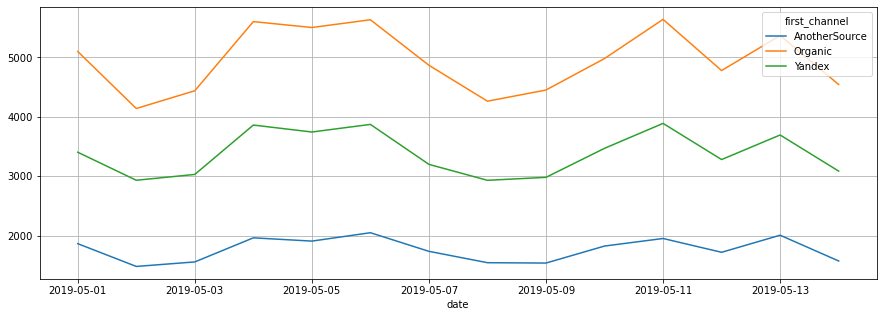

In [18]:
profiles.pivot_table(
    index='date',  # даты первых посещений
    columns='first_channel',  # источники переходов
    values='user_id',  # ID пользователей
    aggfunc='nunique'  # подсчёт уникальных значений
).plot(figsize=(15, 5), grid=True)

plt.show()

### Retention Rate

В цифровых сервисах когортный анализ применяют, чтобы сравнить «качество» пользователей. Один из главных критериев качества — как долго клиент остаётся с компанией. На языке метрик этот факт часто описывают двумя показателями: Retention Rate и Churn Rate.

Retention Rate, или коэффициент удержания, показывает, как долго клиенты остаются с компанией. Сколько пользователей из когорты относительно их изначального числа вернулись, то есть воспользовались продуктом или услугой, в последующие периоды.

Это важнейший показатель для компаний, которые зарабатывают с пользователей напрямую (интернет-магазинов или сервисов по подписке). Ведь чем дольше привлечённый клиент пользуется продуктом, тем больше потенциальная выручка.

Полезен Retention Rate и для зарабатывающих на рекламе компаний — социальных сетей, поисковых систем. Чем дольше клиенты пользуются сервисом, тем больше показов рекламных объявлений можно продать.

Чтобы узнать Retention Rate, нужно разделить количество активных пользователей когорты в нужный день на количество активных пользователей когорты на первый день.

_Например, Retention Rate на разные даты для пользователей от 1 и 2 апреля._

![Пример таблицы удержаний](https://pictures.s3.yandex.net/resources/Retention_Rate_3_1620468175.png)

Лайфтайм - это срок, который существует когорта. Единица измерения лайфтайма - длине периода, на который разделены пользователи по когортам. Если когорты образованы на основе дат - то лайфтайм - это количество полных суток с момента создания когорты. Если по неделям - то количество недель. По месяцам - количество месяцев.

Теперь Retention Rate разных когорт можно сравнивать напрямую. Или вычислить общий Retention Rate для разных когорт: складывать суммы из одинаковых лайфтаймов - а затем по полученному ряду сумм вычислять Retention Rate в тот или иной лайфтайм.

Шаги:

- Собрать таблицу событий:
  - Объединить данные сессий с профилями.
  - Рассчитать лайфтайм пользователя для каждой сессии.
- Построить таблицу долей удержания:
   - Построить таблицу удержания. То есть сводную таблицу, в которой названия строк — это даты первого посещения пользователей, названия столбцов — лайфтайм, а значения в «ячейках» — количество уникальных идентификаторов пользователей.
   - Вычислить размеры когорт и занести результаты в отдельную таблицу.
   - Разделить каждую «ячейку» таблицы удержания на соответствующий размер когорты.

In [19]:
# в данном случае событие - это заход на сайт, сессия
# собираем данные о событиях: к данным о сессиях добавляем данные о профиле пользователя
events = sessions.merge(profiles, on='user_id', how='right')

# вычисляем лайфтайм каждого события в днях
events['lifetime'] = (
    events['session_start'] - events['first_session_start']
).dt.days

events

,user_id,region,device,channel,session_duration,session_start,first_region,first_device,first_channel,first_session_duration,first_session_start,date,month,payer,lifetime
0,10964006,Germany,Mac,Yandex,18.358495,2019-05-12 04:50:17,Germany,Mac,Yandex,18.358495,2019-05-12 04:50:17,2019-05-12,2019-05-01,True,0
1,10964006,Germany,Mac,Yandex,9.317945,2019-05-13 04:00:27,Germany,Mac,Yandex,18.358495,2019-05-12 04:50:17,2019-05-12,2019-05-01,True,0
2,10964006,Germany,Mac,Yandex,21.288979,2019-05-14 04:21:06,Germany,Mac,Yandex,18.358495,2019-05-12 04:50:17,2019-05-12,2019-05-01,True,1
3,12358165,United States,iPhone,Yandex,7.406291,2019-05-10 23:16:24,United States,iPhone,Yandex,7.406291,2019-05-10 23:16:24,2019-05-10,2019-05-01,False,0
4,12358165,United States,iPhone,Yandex,0.953297,2019-05-11 11:01:14,United States,iPhone,Yandex,7.406291,2019-05-10 23:16:24,2019-05-10,2019-05-01,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282932,999954663782,United States,Android,AnotherSource,18.319029,2019-05-04 09:57:28,United States,Android,AnotherSource,18.319029,2019-05-04 09:57:28,2019-05-04,2019-05-01,False,0
282933,999957797889,Russian Federation,Android,Yandex,19.478615,2019-05-14 21:54:26,Russian Federation,Android,Yandex,19.478615,2019-05-14 21:54:26,2019-05-14,2019-05-01,False,0
282934,999974288578,France,iPhone,Organic,4.526489,2019-05-07 03:42:53,France,iPhone,Organic,4.526489,2019-05-07 03:42:53,2019-05-07,2019-05-01,False,0
282935,999996691258,Russian Federation,iPhone,AnotherSource,16.594600,2019-05-05 09:27:58,Russian Federation,iPhone,AnotherSource,16.594600,2019-05-05 09:27:58,2019-05-05,2019-05-01,False,0


In [20]:
# строим таблицу удержания - сколько пользователей из когорты повторили действие в каждый лайфтайм
retention = events.pivot_table(
    index=['date'], columns='lifetime', values='user_id', aggfunc='nunique'
)

retention.astype('Int64')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12,13
date,,,,,,,,,,,,,,
2019-05-01,10369,4213,3059,2415,1993,1750,1473,1418,1250,1107,1013,917,869,404
2019-05-02,8556,3410,2575,1986,1730,1430,1207,1084,992,862,857,803,402,<NA>
2019-05-03,9029,1715,924,551,369,285,238,185,144,123,118,35,<NA>,<NA>
2019-05-04,11426,2143,1200,694,470,339,275,233,199,160,65,<NA>,<NA>,<NA>
2019-05-05,11155,1502,622,378,222,145,129,76,64,37,<NA>,<NA>,<NA>,<NA>
2019-05-06,11554,2839,1584,1114,796,661,503,407,187,<NA>,<NA>,<NA>,<NA>,<NA>
2019-05-07,9804,2343,1429,935,707,529,404,208,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2019-05-08,8741,2558,1654,1160,909,690,312,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2019-05-09,8973,3253,2406,1781,1473,675,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [21]:
# вычисляем размеры когорт
cohort_sizes = (
    # Сгруппируем данные по дате первого посещения из `dt`
    events.groupby('date')
    # и посчитаем количество уникальных пользователей в каждой когорте,
    # применив функцию `nunique` к столбцу `user_id`.
    .agg({'user_id': 'nunique'})
    # теперь это серия, которая содержит размер когорты
    .rename(columns={'user_id': 'cohort_size'})
)

cohort_sizes

,cohort_size
date,
2019-05-01,10369
2019-05-02,8556
2019-05-03,9029
2019-05-04,11426
2019-05-05,11155
2019-05-06,11554
2019-05-07,9804
2019-05-08,8741
2019-05-09,8973


In [22]:
# делим данные таблицы удержания на размеры когорт
retention_rates = retention.div(
    cohort_sizes['cohort_size'], axis=0
)

retention_rates

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12,13
date,,,,,,,,,,,,,,
2019-05-01,1.0,0.406307,0.295014,0.232906,0.192208,0.168772,0.142058,0.136754,0.120552,0.106761,0.097695,0.088437,0.083808,0.038962
2019-05-02,1.0,0.398551,0.300958,0.232118,0.202197,0.167134,0.141071,0.126695,0.115942,0.100748,0.100164,0.093852,0.046985,NaN
2019-05-03,1.0,0.189944,0.102337,0.061026,0.040868,0.031565,0.026360,0.020490,0.015949,0.013623,0.013069,0.003876,NaN,NaN
2019-05-04,1.0,0.187555,0.105024,0.060739,0.041134,0.029669,0.024068,0.020392,0.017416,0.014003,0.005689,NaN,NaN,NaN
2019-05-05,1.0,0.134648,0.055760,0.033886,0.019901,0.012999,0.011564,0.006813,0.005737,0.003317,NaN,NaN,NaN,NaN
2019-05-06,1.0,0.245716,0.137095,0.096417,0.068894,0.057210,0.043535,0.035226,0.016185,NaN,NaN,NaN,NaN,NaN
2019-05-07,1.0,0.238984,0.145757,0.095369,0.072113,0.053958,0.041208,0.021216,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-08,1.0,0.292644,0.189223,0.132708,0.103993,0.078938,0.035694,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-09,1.0,0.362532,0.268138,0.198484,0.164159,0.075226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### `get_attributed_events()`

- `events` - список событий,
- `profiles` - список пользователей,
- `uid` - название колонки с ID пользователя,
- `event_dt` - название колонки, которая содержит время наступления события.

In [23]:
def get_attributed_events(source, profile_source, uid='user_id', event_dt='event_dt'):
    """Возвращает список событий, обогащённый данными о пользователе.
    
    Эти данные полезны, чтобы собирать события в группы.
    """
    attr_events = source.merge(profile_source, on=uid, how='right')

    # вычисляем лайфтайм каждого события в днях
    attr_events['lifetime'] = (
        attr_events[event_dt] - attr_events['first_' + event_dt]
    ).dt.days
    
    return attr_events

In [24]:
attributed_events = get_attributed_events(
    sessions,
    profiles,
    event_dt='session_start',
)

attributed_events

,user_id,region,device,channel,session_duration,session_start,first_region,first_device,first_channel,first_session_duration,first_session_start,date,month,payer,lifetime
0,10964006,Germany,Mac,Yandex,18.358495,2019-05-12 04:50:17,Germany,Mac,Yandex,18.358495,2019-05-12 04:50:17,2019-05-12,2019-05-01,True,0
1,10964006,Germany,Mac,Yandex,9.317945,2019-05-13 04:00:27,Germany,Mac,Yandex,18.358495,2019-05-12 04:50:17,2019-05-12,2019-05-01,True,0
2,10964006,Germany,Mac,Yandex,21.288979,2019-05-14 04:21:06,Germany,Mac,Yandex,18.358495,2019-05-12 04:50:17,2019-05-12,2019-05-01,True,1
3,12358165,United States,iPhone,Yandex,7.406291,2019-05-10 23:16:24,United States,iPhone,Yandex,7.406291,2019-05-10 23:16:24,2019-05-10,2019-05-01,False,0
4,12358165,United States,iPhone,Yandex,0.953297,2019-05-11 11:01:14,United States,iPhone,Yandex,7.406291,2019-05-10 23:16:24,2019-05-10,2019-05-01,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282932,999954663782,United States,Android,AnotherSource,18.319029,2019-05-04 09:57:28,United States,Android,AnotherSource,18.319029,2019-05-04 09:57:28,2019-05-04,2019-05-01,False,0
282933,999957797889,Russian Federation,Android,Yandex,19.478615,2019-05-14 21:54:26,Russian Federation,Android,Yandex,19.478615,2019-05-14 21:54:26,2019-05-14,2019-05-01,False,0
282934,999974288578,France,iPhone,Organic,4.526489,2019-05-07 03:42:53,France,iPhone,Organic,4.526489,2019-05-07 03:42:53,2019-05-07,2019-05-01,False,0
282935,999996691258,Russian Federation,iPhone,AnotherSource,16.594600,2019-05-05 09:27:58,Russian Federation,iPhone,AnotherSource,16.594600,2019-05-05 09:27:58,2019-05-05,2019-05-01,False,0


#### `get_rates()`

- `events` - список действий,
- `dimensions` - список признаков, по которым разделяем на когорты.

In [25]:
def get_rates(events,
              kind='retention',
              dimensions=[]):
    """Возвращает таблицу коэффициентов.
    
    Требует список действий, обогащённый признаками пользователя,
    совершившего действия.
    И тип результата:
    - удержание (повторяющиеся действия, сумма за лайфтайм);
    - конверсия (только первые действия, накопленная сумма)
    """
    ret_kinds = ['retention']
    cr_kinds = ['conversion', 'cr']

    if (
        kind in ret_kinds
        and 'payer' in events.columns
        and not 'payer' in dimensions
    ):
        dimensions = ['payer'] + dimensions

    print('Признаки для анализа:')
    print(dimensions)
    # сколько пользователей совершили действия в каждый лайфтайм
    result = events.pivot_table(
        index=dimensions,
        columns='lifetime',
        values='user_id',
        aggfunc='nunique',
    )

    if kind in cr_kinds:
        result = result.cumsum(axis=1)

    # извлекаем размеры когорт, теперь их нет в сводке
    cohort_sizes = result.pop(0)
    
    # делим количество действовавших пользователей в каждый лайфтайм
    # на размеры когорт - а когорты сформированы в лайфтайме 0!    
    return result.div(cohort_sizes, axis=0)

In [26]:
retention_rates = get_rates(attributed_events, dimensions=['date'])

retention_rates

Признаки для анализа:
['payer', 'date']


lifetime                1         2         3         4         5         6   \
payer date                                                                     
False 2019-05-01  0.393316  0.276885  0.219580  0.178449  0.153171  0.128213   
      2019-05-02  0.383418  0.286518  0.217732  0.189878  0.149732  0.125801   
      2019-05-03  0.174476  0.086190  0.049199  0.032059  0.025647  0.018496   
      2019-05-04  0.171299  0.088989  0.050388  0.030842  0.023770  0.019055   
      2019-05-05  0.121404  0.045714  0.026266  0.014536  0.008321  0.006917   
      2019-05-06  0.229448  0.122782  0.084892  0.057266  0.047194  0.034916   
      2019-05-07  0.226252  0.132607  0.085111  0.059960  0.045026  0.034471   
      2019-05-08  0.279688  0.176930  0.118877  0.090039  0.066994  0.030349   
      2019-05-09  0.346496  0.253949  0.180528  0.150049  0.067004       NaN   
      2019-05-10  0.347198  0.244119  0.185950  0.080197       NaN       NaN   
      2019-05-11  0.355657  0.234255  0.111143       NaN       NaN       NaN   
      2019-05-12  0.382610  0.164056       NaN       NaN       NaN       NaN   
      2019-05-13  0.246337       NaN       NaN       NaN       NaN       NaN   
      2019-05-14       NaN       NaN       NaN       NaN       NaN       NaN   
True  2019-05-01  0.523717  0.458858  0.353340  0.316554  0.309777  0.267183   
      2019-05-02  0.525853  0.422442  0.353135  0.305831  0.313531  0.269527   
      2019-05-03  0.326442  0.244831  0.165397  0.118607  0.083787  0.095756   
      2019-05-04  0.320482  0.236145  0.145382  0.125301  0.077912  0.065060   
      2019-05-05  0.246610  0.140678  0.098305  0.065254  0.052542  0.050847   
      2019-05-06  0.395926  0.269265  0.202834  0.176262  0.149690  0.123118   
      2019-05-07  0.365256  0.276169  0.197105  0.192650  0.142539  0.108018   
      2019-05-08  0.421250  0.311250  0.270000  0.242500  0.197500  0.088750   
      2019-05-09  0.512083  0.400460  0.365938  0.295742  0.151899       NaN   
      2019-05-10  0.519481  0.375541  0.385281  0.178571       NaN       NaN   
      2019-05-11  0.494759  0.410901  0.213836       NaN       NaN       NaN   
      2019-05-12  0.588863  0.267773       NaN       NaN       NaN       NaN   
      2019-05-13  0.373045       NaN       NaN       NaN       NaN       NaN   
      2019-05-14       NaN       NaN       NaN       NaN       NaN       NaN   

lifetime                7         8         9         10        11        12  \
payer date                                                                     
False 2019-05-01  0.124250  0.106577  0.095973  0.085261  0.076907  0.072194   
      2019-05-02  0.112855  0.100562  0.087485  0.086570  0.081078  0.039885   
      2019-05-03  0.015536  0.010111  0.008261  0.009741  0.002589       NaN   
      2019-05-04  0.013653  0.011197  0.009036  0.003340       NaN       NaN   
      2019-05-05  0.003910  0.003208  0.001704       NaN       NaN       NaN   
      2019-05-06  0.027338  0.012182       NaN       NaN       NaN       NaN   
      2019-05-07  0.016506       NaN       NaN       NaN       NaN       NaN   
      2019-05-08       NaN       NaN       NaN       NaN       NaN       NaN   
      2019-05-09       NaN       NaN       NaN       NaN       NaN       NaN   
      2019-05-10       NaN       NaN       NaN       NaN       NaN       NaN   
      2019-05-11       NaN       NaN       NaN       NaN       NaN       NaN   
      2019-05-12       NaN       NaN       NaN       NaN       NaN       NaN   
      2019-05-13       NaN       NaN       NaN       NaN       NaN       NaN   
      2019-05-14       NaN       NaN       NaN       NaN       NaN       NaN   
True  2019-05-01  0.249758  0.246854  0.204259  0.210068  0.192643  0.188771   
      2019-05-02  0.243124  0.245325  0.212321  0.214521  0.201320  0.106711   
      2019-05-03  0.064200  0.067465  0.060936  0.042437  0.015234       NaN   
      2019-05-04  0.075502  0.068273  0.054618  0.024900       NaN       NaN   

### Churn Rate

Churn Rate (коэффициент "оттока") - это доля тех из когорты, кто не повторил действие в следующем периоде. Доля тех, кто перестал пользоваться услугами. Доля "ушедших" пользователей.

    Churn Rate = 1 - (current retention / previous retention)

Отличается от Retention Rate тем, что Retention Rate - это отношение результата лайфтайма к результату нулевого лайфтайма, а Churn Rate - к результату предыдущего лайфтайма.

### Учёт момента и горизонта анализа

#### Алгоритм

**Момент анализа данных** - это момент времени, который нужно отобразить в результатах анализа. Что в этот момент происходило? Как всё выглядело?

**Горизонт анализа данных** - максимальный лайфтайм, который мы включаем в анализ.

Эти ограничения вносятся, чтобы внимание аналитика сосредоточилось на вещах, которые заведомо сопоставимы. Одинаковые лайфтаймы чтобы были в каждой когорте.

Вот пример того, как умело ограничить данные, чтобы потом получить разумный результат: подсчёт среднего удержания за неделю. Естественно, берём только те когорты, которые прожили не меньше недели. Таких только две, а не все.

![Как ограничивают таблицу результатов](https://pictures.s3.yandex.net/resources/Churn_Rate_4_1620471412.png)

Чтобы учесть момент и горизонт анализа, нужно:

- Задать момент и горизонт анализа.
- Рассчитать самую позднюю подходящую дату привлечения пользователей.
- Выбрать пользователей, пришедших не позже подходящей даты.
- Выбрать события с лайфтаймом меньше (**?**) чем горизонт анализа.

**?** Вопрос: почему именно "меньше" а не "не больше"? Ведь если мы хотим знать, как поступают люди через 7 дней, то нам нужно знать, что они делают на 8-ый день. То есть, через 7 дней. То есть, включая лайфтайм, который равен горизонту.

In [27]:
horizon = 6
observation_date = datetime.date(2019, 5, 13)

if profiles is None:
    # создаём профили пользователей, используя записи об их посещениях
    profiles = get_profiles(sessions, event_dt='session_start')

if not observation_date:
    observation_date = sessions['session_start'].dt.date.max()

# Последний приемлимый период - это дата наблюдения.
# Исходя из того, что за эту дату есть полные данные,
# это не должна быть сегодняшняя дата -
# данные за сегодня не полны, день не кончился.
# По умолчанию, последний приемлемый период - "день наблюдения".
last_suitable_acquisition_date = observation_date
# Но если задан горизонт наблюдений,
if horizon:
    # то последний приемлемый период - тот, который настал на
    # {horizon} периодов перед {observation_date}.
    last_suitable_acquisition_date -= datetime.timedelta(days=horizon - 1)

# исключаем профили, которые слишком молоды,
# чтобы прожить нужное количество периодов
# "у них максимальный лайфтайм меньше чем горизонт анализа"
suitable_profiles = profiles.query('date <= @last_suitable_acquisition_date')

# дополняем данные только теми, которые в нужных профилях
attributed_events = get_attributed_events(sessions, profile_source=suitable_profiles, event_dt='session_start')

# по умолчанию считаем, что любые лайфтаймы нас устроят
suitable_events = attributed_events
# но если указан горизонт анализа - то...
if horizon:
    # оставляем только записи с лайфтаймами,
    # которые меньше чем горизонт анализа
    suitable_events = attributed_events.query('lifetime < @horizon')

get_rates(suitable_events, dimensions=['date'])

Признаки для анализа:
['payer', 'date']


lifetime                 1         2         3         4         5
payer date                                                        
False 2019-05-01  0.393316  0.276885  0.219580  0.178449  0.153171
      2019-05-02  0.383418  0.286518  0.217732  0.189878  0.149732
      2019-05-03  0.174476  0.086190  0.049199  0.032059  0.025647
      2019-05-04  0.171299  0.088989  0.050388  0.030842  0.023770
      2019-05-05  0.121404  0.045714  0.026266  0.014536  0.008321
      2019-05-06  0.229448  0.122782  0.084892  0.057266  0.047194
      2019-05-07  0.226252  0.132607  0.085111  0.059960  0.045026
      2019-05-08  0.279688  0.176930  0.118877  0.090039  0.066994
True  2019-05-01  0.523717  0.458858  0.353340  0.316554  0.309777
      2019-05-02  0.525853  0.422442  0.353135  0.305831  0.313531
      2019-05-03  0.326442  0.244831  0.165397  0.118607  0.083787
      2019-05-04  0.320482  0.236145  0.145382  0.125301  0.077912
      2019-05-05  0.246610  0.140678  0.098305  0.065254  0.052542
      2019-05-06  0.395926  0.269265  0.202834  0.176262  0.149690
      2019-05-07  0.365256  0.276169  0.197105  0.192650  0.142539
      2019-05-08  0.421250  0.311250  0.270000  0.242500  0.197500

#### `get_suitable_events()`

- `events` — данные журнала событий (сессий/посещений, регистраций, установок, покупок...),
- `dimensions` - список признаков, по которым разделяем на когорты (по умолчанию не заданы),
- `observation_date` — момент анализа (по умолчанию не задан),
- `horizon` — горизонт анализа в днях (по умолчанию не задан),
- `profiles` — профили пользователей (по умолчанию не заданы).

In [28]:
def get_suitable_events(events,
                        dimensions=[],
                        event_dt='event_dt',
                        observation_date=None,
                        horizon=None,
                        profiles=None):
    """Возвращает список подходящих для анализа событий.
    
    В списке только события пользователей,
    проживших до горизонта анализа к моменту анализа.
    Все события дополнены признаками пользователя
    и готовы к подсчёту статистики об удержании пользователя.
    """
    if profiles is None:
        # создаём профили пользователей, используя записи об их посещениях
        profiles = get_profiles(events, event_dt=event_dt)

    if not observation_date:
        observation_date = events[event_dt].dt.date.max()

    # Последний приемлимый период - это дата наблюдения.
    # Исходя из того, что за эту дату есть полные данные,
    # это не должна быть сегодняшняя дата -
    # данные за сегодня не полны, день не кончился.
    # По умолчанию, последний приемлемый период - "день наблюдения".
    last_suitable_acquisition_date = observation_date
    # Но если задан горизонт наблюдений,
    if horizon:
        # то последний приемлемый период - тот, который настал на
        # {horizon} периодов перед {observation_date}.
        last_suitable_acquisition_date -= datetime.timedelta(days=horizon - 1)

    # исключаем профили, которые слишком молоды,
    # чтобы прожить нужное количество периодов
    # "у них максимальный лайфтайм меньше чем горизонт анализа"
    suitable_profiles = profiles.query('date <= @last_suitable_acquisition_date')

    # дополняем данные только теми, которые в нужных профилях
    attributed_events = get_attributed_events(events, profile_source=suitable_profiles, event_dt=event_dt)

    # по умолчанию считаем, что любые лайфтаймы нас устроят
    suitable_events = attributed_events
    
    # но если указан горизонт анализа - то...
    if horizon:
        # оставляем только записи с лайфтаймами,
        # которые меньше чем горизонт анализа
        suitable_events = suitable_events.query('lifetime < @horizon')

    return suitable_events

#### `get_retention()`

- `events` — данные журнала событий (сессий/посещений, регистраций, установок, покупок...),
- `dimensions` - список признаков, по которым разделяем на когорты (по умолчанию не заданы),
- `observation_date` — момент анализа (по умолчанию не задан),
- `horizon` — горизонт анализа в днях (по умолчанию не задан),
- `profiles` — профили пользователей (по умолчанию не заданы).

In [29]:
def get_retention(events, event_dt='event_dt', dimensions=[], observation_date=None, horizon=None, profiles=None):
    """Возвращает статистику удержания пользователей.
    
    Требует только журнал событий.
    """
    suitable_events = get_suitable_events(
        events=events,
        event_dt=event_dt,
        dimensions=dimensions,
        observation_date=observation_date,
        horizon=horizon,
        profiles=profiles,
    )

    result = get_rates(suitable_events, kind='retention', dimensions=dimensions)
    return suitable_events, result

In [30]:
events, retention = get_retention(
    events=sessions,
    event_dt='session_start',
    dimensions=['date'],
    observation_date=datetime.date(2019, 5, 13),
    horizon=6,
)

Переименованные колонки:
'region' => 'first_region'
'device' => 'first_device'
'channel' => 'first_channel'
'session_duration' => 'first_session_duration'
'session_start' => 'first_session_start'

Признаки для анализа:
['date']


In [31]:
retention

lifetime,1,2,3,4,5
date,,,,,
2019-05-01,0.406307,0.295014,0.232906,0.192208,0.168772
2019-05-02,0.398551,0.300958,0.232118,0.202197,0.167134
2019-05-03,0.189944,0.102337,0.061026,0.040868,0.031565
2019-05-04,0.187555,0.105024,0.060739,0.041134,0.029669
2019-05-05,0.134648,0.055760,0.033886,0.019901,0.012999
2019-05-06,0.245716,0.137095,0.096417,0.068894,0.057210
2019-05-07,0.238984,0.145757,0.095369,0.072113,0.053958
2019-05-08,0.292644,0.189223,0.132708,0.103993,0.078938


In [32]:
events

,user_id,region,device,channel,session_duration,session_start,first_region,first_device,first_channel,first_session_duration,first_session_start,date,month,lifetime
0,12545358,United States,Mac,Organic,44.586078,2019-05-05 19:22:46,United States,Mac,Organic,44.586078,2019-05-05 19:22:46,2019-05-05,2019-05-01,0
1,12545358,United States,Mac,Organic,16.607699,2019-05-06 03:18:30,United States,Mac,Organic,44.586078,2019-05-05 19:22:46,2019-05-05,2019-05-01,0
2,47343201,United States,iPhone,Organic,14.140214,2019-05-07 16:55:48,United States,iPhone,Organic,14.140214,2019-05-07 16:55:48,2019-05-07,2019-05-01,0
3,51602715,Russian Federation,iPhone,Organic,34.443342,2019-05-03 14:57:36,Russian Federation,iPhone,Organic,34.443342,2019-05-03 14:57:36,2019-05-03,2019-05-01,0
4,51602715,Russian Federation,iPhone,Organic,1.793384,2019-05-04 19:08:27,Russian Federation,iPhone,Organic,34.443342,2019-05-03 14:57:36,2019-05-03,2019-05-01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171773,999939571625,Germany,iPhone,Yandex,35.694236,2019-05-10 23:13:21,Germany,iPhone,Yandex,21.279067,2019-05-08 17:47:00,2019-05-08,2019-05-01,2
171774,999954663782,United States,Android,AnotherSource,18.319029,2019-05-04 09:57:28,United States,Android,AnotherSource,18.319029,2019-05-04 09:57:28,2019-05-04,2019-05-01,0
171775,999974288578,France,iPhone,Organic,4.526489,2019-05-07 03:42:53,France,iPhone,Organic,4.526489,2019-05-07 03:42:53,2019-05-07,2019-05-01,0
171776,999996691258,Russian Federation,iPhone,AnotherSource,16.594600,2019-05-05 09:27:58,Russian Federation,iPhone,AnotherSource,16.594600,2019-05-05 09:27:58,2019-05-05,2019-05-01,0


### Визуализация

#### `show_heatmap_table()` - тепловая карта удержания

Хитмэп — отличный выбор, если вы хотите сравнить удержание нескольких когорт.

In [33]:
def show_heatmap_table(retention, figsize=(15, 6)):
    """Показывает единую тепловую карту удержаний.
    """
    plt.figure(figsize=figsize)
    sns.heatmap(
        retention,
        annot=True,  # включаем подписи
        fmt='.2%',  # переводим значения в проценты
    )
    plt.title('Тепловая карта удержания')  # название графика
    plt.show()

Переименованные колонки:
'region' => 'first_region'
'device' => 'first_device'
'channel' => 'first_channel'
'session_duration' => 'first_session_duration'
'session_start' => 'first_session_start'

Признаки для анализа:
['date']


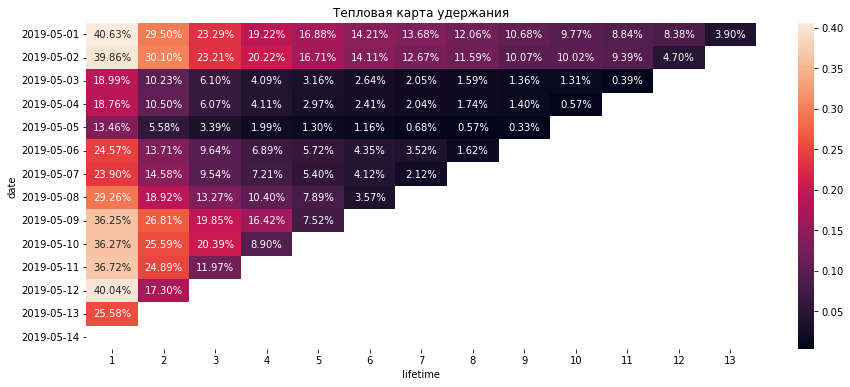

In [34]:
_, triangle_retention = get_retention(sessions, event_dt='session_start', dimensions=['date'])
show_heatmap_table(triangle_retention)

#### Кривая удержания

Кривые удержания подходят для «быстрого» сравнения показателей. Метод `plot()` строит график, на котором линии отражают значения каждого столбца датафрейма.

In [35]:
retention

lifetime,1,2,3,4,5
date,,,,,
2019-05-01,0.406307,0.295014,0.232906,0.192208,0.168772
2019-05-02,0.398551,0.300958,0.232118,0.202197,0.167134
2019-05-03,0.189944,0.102337,0.061026,0.040868,0.031565
2019-05-04,0.187555,0.105024,0.060739,0.041134,0.029669
2019-05-05,0.134648,0.055760,0.033886,0.019901,0.012999
2019-05-06,0.245716,0.137095,0.096417,0.068894,0.057210
2019-05-07,0.238984,0.145757,0.095369,0.072113,0.053958
2019-05-08,0.292644,0.189223,0.132708,0.103993,0.078938


In [36]:
# транспонирование (переворачивание) таблицы с помощью атрибута T:
# столбцы становятся строками, а строки - столбцами
test = retention.T

test

date,2019-05-01,2019-05-02,2019-05-03,2019-05-04,2019-05-05,2019-05-06,2019-05-07,2019-05-08
lifetime,,,,,,,,
1,0.406307,0.398551,0.189944,0.187555,0.134648,0.245716,0.238984,0.292644
2,0.295014,0.300958,0.102337,0.105024,0.055760,0.137095,0.145757,0.189223
3,0.232906,0.232118,0.061026,0.060739,0.033886,0.096417,0.095369,0.132708
4,0.192208,0.202197,0.040868,0.041134,0.019901,0.068894,0.072113,0.103993
5,0.168772,0.167134,0.031565,0.029669,0.012999,0.057210,0.053958,0.078938


In [37]:
# это способ получить названия строк
test.index.values

array([1, 2, 3, 4, 5], dtype=int64)

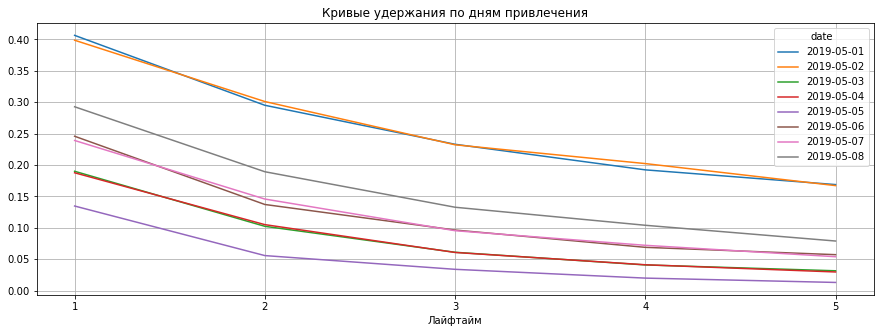

In [38]:
# строим кривые удержания
retention.T.plot(
    grid=True,
    # отметки на оси X — названия колонок retention, то есть - номера лайфтаймов
    xticks=list(retention.columns),
    figsize=(15, 5),
)
plt.xlabel('Лайфтайм')  # название оси X
plt.title('Кривые удержания по дням привлечения')  # название графика
plt.show()

#### Кривые истории изменения удержаний

Если задача — проанализировать, как менялось удержание от когорты к когорте для каждого дня «жизни» пользователей, подойдёт график истории изменений.

Построить такой график проще всего — достаточно вызвать `plot()` к таблице удержания. Без всякого транспонирования.

Каждая линия на этом графике показывает, как менялось удержание пользователей на определённый лайфтайм. Например, синяя линия сверху отражает изменения в удержании второго дня или первого лайфтайма (лайфтайм 1 - прошёл один полный день, идёт второй), а нижняя фиолетовая — в удержании шестого дня.

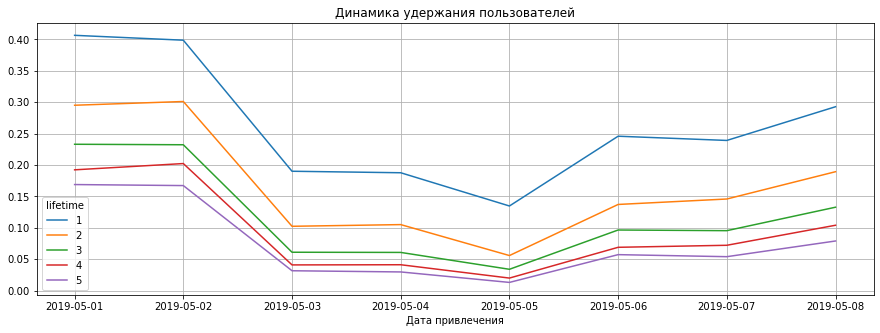

In [39]:
# строим графики изменений
retention.plot(grid=True, figsize=(15, 5))
plt.xlabel('Дата привлечения')
plt.title('Динамика удержания пользователей')
plt.show()

In [40]:
profiles

,user_id,first_region,first_device,first_channel,first_session_duration,first_session_start,date,month,payer
0,10964006,Germany,Mac,Yandex,18.358495,2019-05-12 04:50:17,2019-05-12,2019-05-01,True
1,12358165,United States,iPhone,Yandex,7.406291,2019-05-10 23:16:24,2019-05-10,2019-05-01,False
2,12545358,United States,Mac,Organic,44.586078,2019-05-05 19:22:46,2019-05-05,2019-05-01,False
3,16165560,United States,PC,Yandex,2.550662,2019-05-10 20:29:59,2019-05-10,2019-05-01,False
4,17733464,France,iPhone,Organic,1.065799,2019-05-12 11:08:25,2019-05-12,2019-05-01,True
...,...,...,...,...,...,...,...,...,...
141414,999939571625,Germany,iPhone,Yandex,21.279067,2019-05-08 17:47:00,2019-05-08,2019-05-01,False
141415,999954663782,United States,Android,AnotherSource,18.319029,2019-05-04 09:57:28,2019-05-04,2019-05-01,False
141416,999957797889,Russian Federation,Android,Yandex,19.478615,2019-05-14 21:54:26,2019-05-14,2019-05-01,False
141417,999974288578,France,iPhone,Organic,4.526489,2019-05-07 03:42:53,2019-05-07,2019-05-01,False


In [41]:
pd.read_csv(URL + 'profiles_backup.csv')

,user_id,first_ts,channel,device,region,dt,month,payer
0,10964006,2019-05-12 04:50:17,Yandex,Mac,Germany,2019-05-12,2019-05-01 00:00:00,True
1,12358165,2019-05-10 23:16:24,Yandex,iPhone,United States,2019-05-10,2019-05-01 00:00:00,False
2,12545358,2019-05-05 19:22:46,Organic,Mac,United States,2019-05-05,2019-05-01 00:00:00,False
3,16165560,2019-05-10 20:29:59,Yandex,PC,United States,2019-05-10,2019-05-01 00:00:00,False
4,17733464,2019-05-12 11:08:25,Organic,iPhone,France,2019-05-12,2019-05-01 00:00:00,True
...,...,...,...,...,...,...,...,...
141414,999939571625,2019-05-08 17:47:00,Yandex,iPhone,Germany,2019-05-08,2019-05-01 00:00:00,False
141415,999954663782,2019-05-04 09:57:28,AnotherSource,Android,United States,2019-05-04,2019-05-01 00:00:00,False
141416,999957797889,2019-05-14 21:54:26,Yandex,Android,Russian Federation,2019-05-14,2019-05-01 00:00:00,False
141417,999974288578,2019-05-07 03:42:53,Organic,iPhone,France,2019-05-07,2019-05-01 00:00:00,False


In [42]:
events, retention = get_retention(
    sessions, event_dt='session_start',
    profiles=profiles,
    observation_date=datetime.date(2019, 5, 13),
    horizon=6,
    dimensions=['payer'],
)

Признаки для анализа:
['payer']


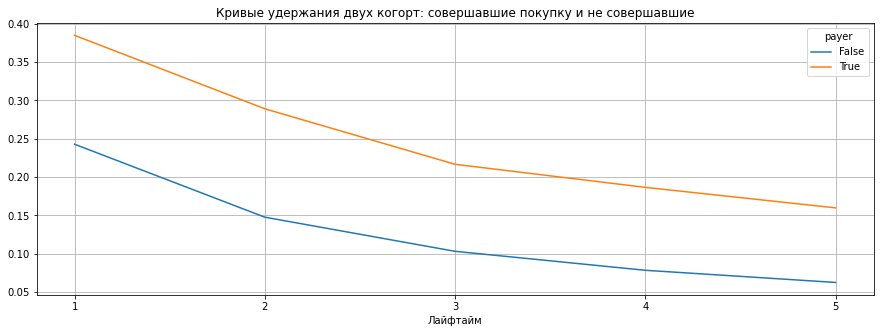

In [43]:
# строим тепловую карту
retention.T.plot(grid=True, xticks=retention.columns, figsize=(15, 5))
plt.xlabel('Лайфтайм')
plt.title('Кривые удержания двух когорт: совершавшие покупку и не совершавшие')
plt.show()

### Графики, которые отображают когорты с двумя-тремя признаками

Удержание платящих значительно выше удержания неплатящих. Так бывает почти всегда, поэтому разбивка пользователей на платящих и неплатящих — стандартная практика. Мы дополнили `get_retention`, он учитывает разбивкуй на когорты: плательщики и лиды.

In [44]:
events, retention = get_retention(
    sessions, event_dt='session_start',
    # а следующий фрейм содержит колонку `payer`
    # если колонку или весь фрейм убрать - то разбивка
    # на тех кто платил и кто не платил - исчезнет
    profiles=profiles,
    observation_date=datetime.date(2019, 5, 13),
    horizon=6,
    dimensions=['date']
)

retention

Признаки для анализа:
['payer', 'date']


lifetime                 1         2         3         4         5
payer date                                                        
False 2019-05-01  0.393316  0.276885  0.219580  0.178449  0.153171
      2019-05-02  0.383418  0.286518  0.217732  0.189878  0.149732
      2019-05-03  0.174476  0.086190  0.049199  0.032059  0.025647
      2019-05-04  0.171299  0.088989  0.050388  0.030842  0.023770
      2019-05-05  0.121404  0.045714  0.026266  0.014536  0.008321
      2019-05-06  0.229448  0.122782  0.084892  0.057266  0.047194
      2019-05-07  0.226252  0.132607  0.085111  0.059960  0.045026
      2019-05-08  0.279688  0.176930  0.118877  0.090039  0.066994
True  2019-05-01  0.523717  0.458858  0.353340  0.316554  0.309777
      2019-05-02  0.525853  0.422442  0.353135  0.305831  0.313531
      2019-05-03  0.326442  0.244831  0.165397  0.118607  0.083787
      2019-05-04  0.320482  0.236145  0.145382  0.125301  0.077912
      2019-05-05  0.246610  0.140678  0.098305  0.065254  0.052542
      2019-05-06  0.395926  0.269265  0.202834  0.176262  0.149690
      2019-05-07  0.365256  0.276169  0.197105  0.192650  0.142539
      2019-05-08  0.421250  0.311250  0.270000  0.242500  0.197500

#### Тепловые карты удержания

Видим, что у нас составной индекс.

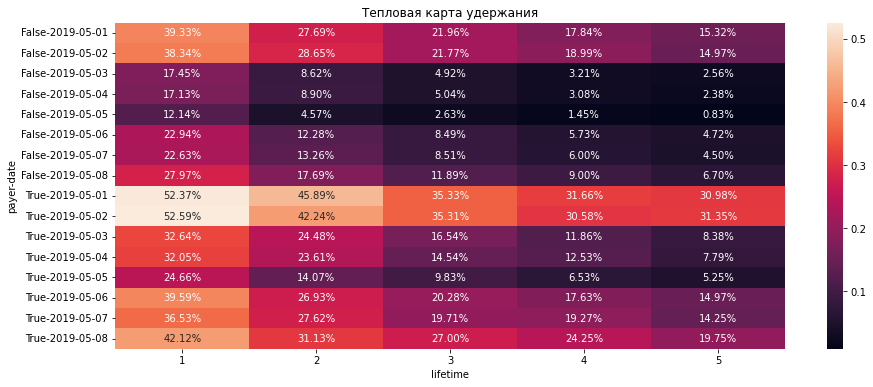

In [45]:
show_heatmap_table(retention)

Теперь каждой строке таблицы удержания соответствуют два параметра: дата и признак совершения покупки. График и подписи заметно разрослись.

Разделим график надвое: построим по тепловой карте для каждой группы пользователей — платящих и неплатящих. Для этого вызовем функцию `figure()` из модуля `pyplot` библиотеки `matplotlib` и напишем цикл `for`.

In [46]:
retention

lifetime                 1         2         3         4         5
payer date                                                        
False 2019-05-01  0.393316  0.276885  0.219580  0.178449  0.153171
      2019-05-02  0.383418  0.286518  0.217732  0.189878  0.149732
      2019-05-03  0.174476  0.086190  0.049199  0.032059  0.025647
      2019-05-04  0.171299  0.088989  0.050388  0.030842  0.023770
      2019-05-05  0.121404  0.045714  0.026266  0.014536  0.008321
      2019-05-06  0.229448  0.122782  0.084892  0.057266  0.047194
      2019-05-07  0.226252  0.132607  0.085111  0.059960  0.045026
      2019-05-08  0.279688  0.176930  0.118877  0.090039  0.066994
True  2019-05-01  0.523717  0.458858  0.353340  0.316554  0.309777
      2019-05-02  0.525853  0.422442  0.353135  0.305831  0.313531
      2019-05-03  0.326442  0.244831  0.165397  0.118607  0.083787
      2019-05-04  0.320482  0.236145  0.145382  0.125301  0.077912
      2019-05-05  0.246610  0.140678  0.098305  0.065254  0.052542
      2019-05-06  0.395926  0.269265  0.202834  0.176262  0.149690
      2019-05-07  0.365256  0.276169  0.197105  0.192650  0.142539
      2019-05-08  0.421250  0.311250  0.270000  0.242500  0.197500

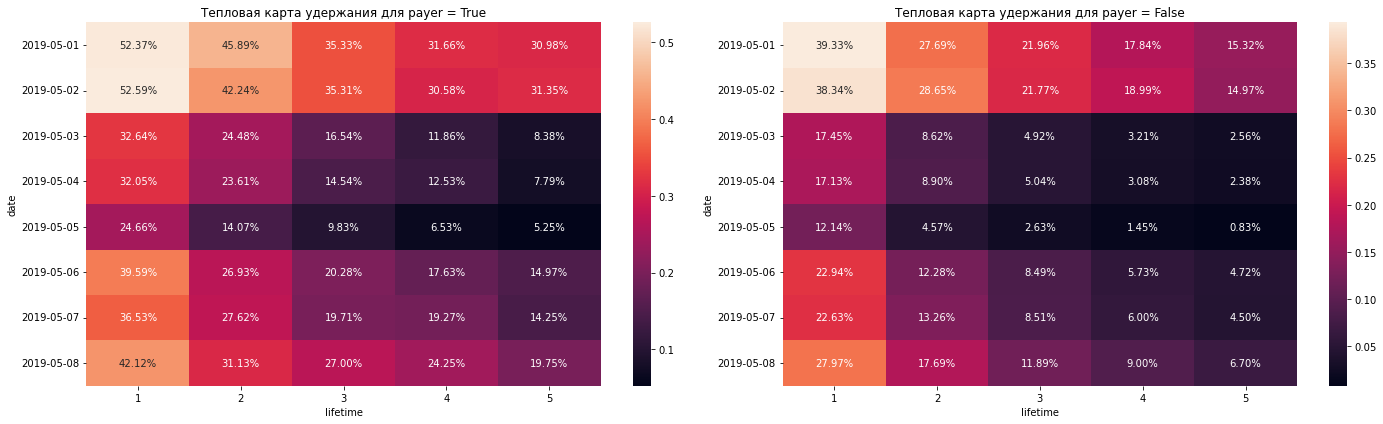

In [47]:
plt.figure(figsize=(20, 6)) # задаём размер холста для графиков

# берём порядковый номер и имя категории
# а категорий всего две: "платил" и "не платил"
for i, payer in enumerate(profiles['payer'].unique()):
    sns.heatmap(
        # из всей таблицы удержаний берём только те записи,
        # где индекс 'payer' равен значению 'payer' из итератора
        retention.query('payer == @payer')
        # удаляем индекс payer - он теперь не нужен
        .droplevel('payer'),
        # добавляем подписи значений
        annot=True,
        # переводим значения в проценты
        fmt='.2%',
        # строим каждый график в своей ячейке
        # (number_of_rows, number_of_cols, index)
        # index starts at 1 in the upper left corner and increases to the right.
        # index can also be a two-tuple specifying the (first, last) indices
        # (1-based, and including last) of the subplot,
        # e.g., fig.add_subplot(3, 1, (1, 2)) makes a subplot
        # that spans the upper 2/3 of the figure.
        ax=plt.subplot(1, 2, i + 1),
    )
    # задаём названия графиков с учётом значения payer
    plt.title('Тепловая карта удержания для payer = {}'.format(payer))

plt.tight_layout()  # «подгоняем» размер графиков, чтобы уместились подписи
plt.show()

В программе для построения двух хитмэпов мы передали функции `subplot()` аргументы `1`, `2` и `i + 1`: в таблице графиков одна строка и два столбца. 

```python
        ax=plt.subplot(1, 2, i + 1)
```

Переменная `i` принимает значения `0` и `1`, а нумерация ячеек в таблице графиков начинается с единицы, поэтому значение `i` увеличиваем на один. Так первый график окажется в первой ячейке, а второй — во второй.

#### Кривые удержания

Проанализируем удержание с разбивкой когорт не по дате, а по другому параметру — устройству, с которого пользователи впервые зашли на сайт. Эта информация сохранена в столбце `device` — добавим его в параметр `dimensions`. Горизонт и момент анализа данных остаются прежними. Вызовем функцию `get_retention()` и построим хитмэп.

In [48]:
_, retention = get_retention(
    sessions,
    event_dt='session_start',
    profiles=profiles,
    observation_date=datetime.date(2019, 5, 13),
    horizon=6,
    dimensions=['device'],
)

retention

Признаки для анализа:
['payer', 'device']


lifetime              1         2         3         4         5
payer device                                                   
False Android  0.249110  0.145947  0.103026  0.076602  0.061131
      Mac      0.237466  0.148007  0.099782  0.076898  0.063299
      PC       0.234800  0.143664  0.102167  0.081944  0.064347
      iPhone   0.242112  0.147360  0.103771  0.078159  0.061382
True  Android  0.374312  0.291131  0.219572  0.169419  0.151682
      Mac      0.393175  0.291296  0.232443  0.184965  0.149852
      PC       0.387731  0.280093  0.214120  0.185185  0.138889
      iPhone   0.378364  0.285404  0.202772  0.191356  0.170427

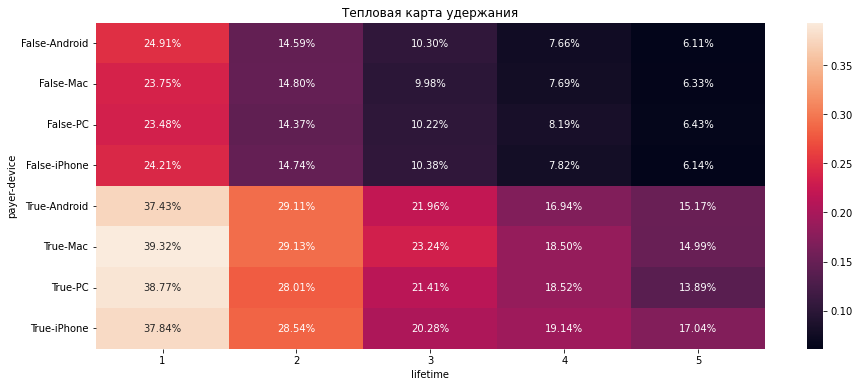

In [49]:
plt.figure(figsize=(15, 6))
sns.heatmap(retention, annot=True, fmt='.2%')
plt.title('Тепловая карта удержания')
plt.show()

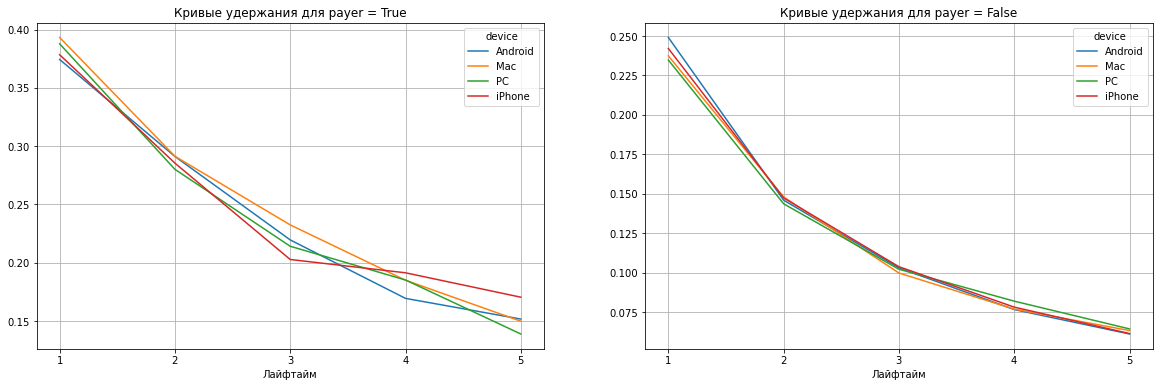

In [50]:
plt.figure(figsize=(20, 6))
for i, payer in enumerate(profiles['payer'].unique()):
    retention.query('payer == @payer').droplevel('payer').T.plot(
        grid=True,
        xticks=retention.columns,
        ax=plt.subplot(1, 2, i + 1),
    )
    plt.xlabel('Лайфтайм')
    plt.title('Кривые удержания для payer = {}'.format(payer))

plt.show()

По правому графику с кривыми удержания неплатящих пользователей сложно определить, пользователи каких устройств удерживаются хоть сколько-то лучше.

#### Кривые истории изменений удержания

Избежать слияния линий позволит третий изученный вами способ визуализации — график истории изменений. На таком графике каждая линия соответствует определённому лайфтайму, а по горизонтальной оси отмечены даты привлечения пользователей. 

Однако построить его теперь непросто: после добавления параметра `dimensions` даты привлечения пользователей пропали из таблицы удержания.

История изменений удержания - это по сути анализ когорт, у которых главный признак - период, в который когорта пришла. Даты становятся обязательным признаком.

In [51]:
_, retention = get_retention(
    sessions, event_dt='session_start',
    profiles=profiles,
    observation_date=datetime.date(2019, 5, 13),
    horizon=6,
    dimensions=['device', 'date'],
)

retention

Признаки для анализа:
['payer', 'device', 'date']


lifetime                         1         2         3         4         5
payer device  date                                                        
False Android 2019-05-01  0.390193  0.274909  0.210224  0.164841  0.151800
              2019-05-02  0.401671  0.282776  0.220437  0.181877  0.145244
              2019-05-03  0.183486  0.089908  0.051376  0.031193  0.023853
              2019-05-04  0.169783  0.088583  0.049213  0.031004  0.020177
              2019-05-05  0.130029  0.043180  0.030913  0.015211  0.008342
...                            ...       ...       ...       ...       ...
True  iPhone  2019-05-04  0.310909  0.238182  0.129091  0.129091  0.085455
              2019-05-05  0.253188  0.127505  0.087432  0.069217  0.051002
              2019-05-06  0.376016  0.260163  0.168699  0.178862  0.156504
              2019-05-07  0.343284  0.286070  0.161692  0.191542  0.159204
              2019-05-08  0.410765  0.334278  0.280453  0.243626  0.220963

[64 rows x 5 columns]

Получаем таблицу удержания, сгруппированную по трём признакам:

- Совершение покупок. Столбец `payer`, значение `True` или `False`.
- Устройство, с которого пользователь просматривает сайт. Столбец `device`, значения `Android`, `Mac`, `PC` или `iPhone`.
- Дата привлечения пользователей. Столбец `dt` с датами от 1 до 8 мая 2019 года.

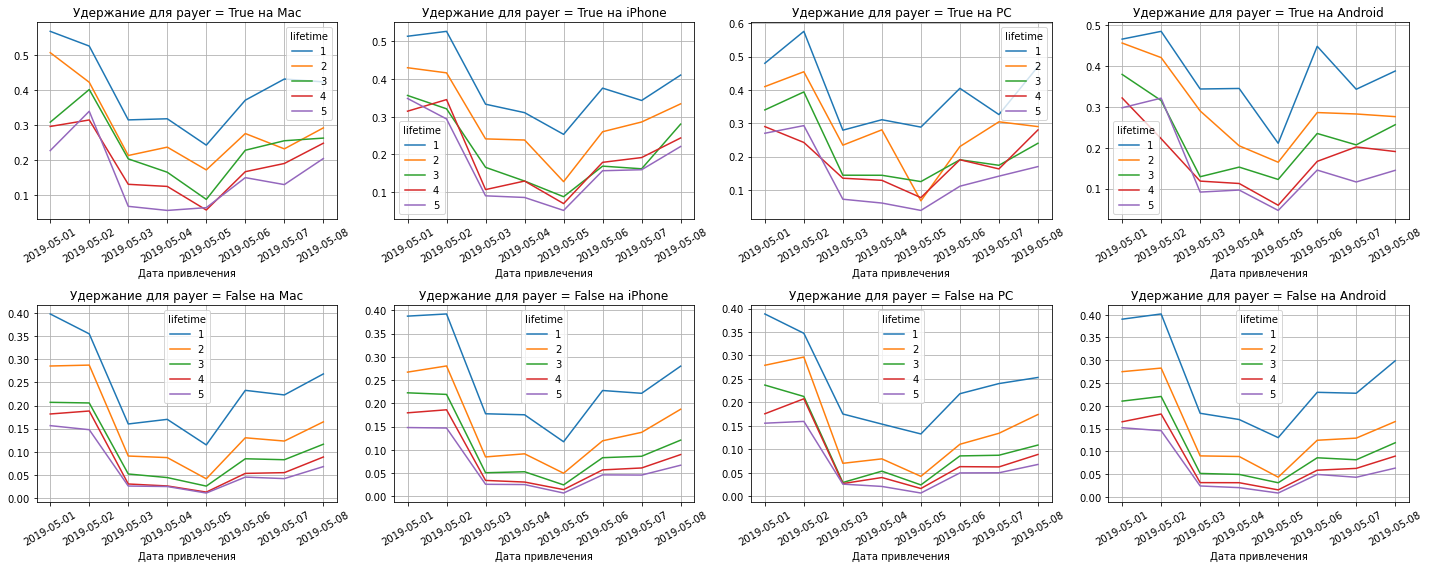

In [52]:
# холст для графиков будет такого размера
plt.figure(figsize=(20, 8))

# на холст графики станут в столько рядов,
# сколько вариантов в 'payer'
nrows = len(profiles['payer'].unique())
# и столько столбцов, сколько вариантов в 'payer'
ncols = len(profiles['first_device'].unique())

# наружний цикл - перебор строк, рядов
for i, payer in enumerate(profiles['payer'].unique()):
    # внутренний цикл - перебо столбцов, позиций в ряду
    for j, device in enumerate(profiles['first_device'].unique()):
        (
            # оставляем записи, в которых нужный статус плательщика и нужное устройство
            retention.query('payer == @payer and device == @device')
            .droplevel(['payer', 'device'])
            .plot(
                grid=True,
                # количество рядов и ячеек в ряду - берутся из констант, заданных до цикла
                # номер ячейки, куда запишем диаграмму - вычисляется
                # на основе порядковых номеров итераций циклов
                ax=plt.subplot(nrows, ncols, i * ncols + j + 1),
                rot=30,
            )
        )
        plt.xlabel('Дата привлечения')
        plt.title('Удержание для payer = {} на {}'.format(payer, device))

# Adjust the padding between and around subplots
plt.tight_layout()
plt.show()

#### Неудачные кривые удержания - когда признаков больше двух

В принципе, это же можно увидеть и на обычных линейных графиках удержания. Построим их, запустив код, который мы использовали для одного дополнительного признака, но теперь  - с двумя дополнительными.

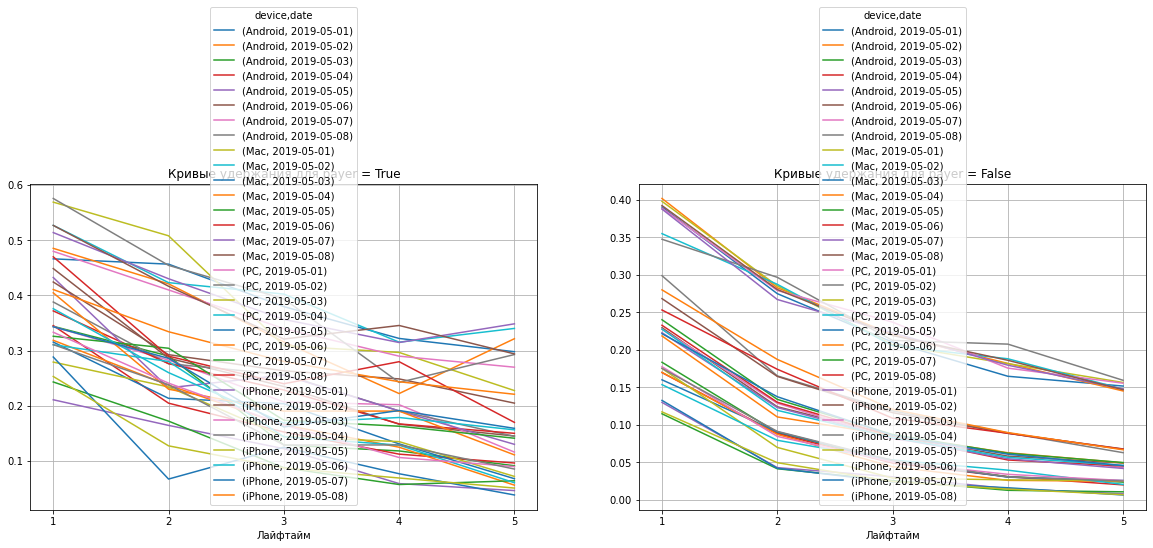

In [53]:
plt.figure(figsize=(20, 6))  # задаём размер сетки

for i, payer in enumerate(profiles['payer'].unique()):
    retention.query('payer == @payer').droplevel('payer').T.plot(
        grid=True,
        xticks=retention.columns,
        ax=plt.subplot(1, 2, i + 1), # задаём расположение графиков
    )
    plt.xlabel('Лайфтайм')
    plt.title('Кривые удержания для payer = {}'.format(payer))

plt.show()

Итак, каждая линия - когорта по трём признакам. Один признак - платежи, по ним когорты распределены вправо и влево. В целом, было бы удобнее распределить их так, как в примере с историей удержания - по горизонтали устройста, по вертикали - наличие платежей.

#### Удачные графики удержания, если много двух признаков

Чтобы построить кривые удержания с разбивкой по совершению покупок и устройствам, параметру `dimensions` при вызове функции `get_retention()` нужно передать только столбец `device`. Перегруппировать текущую таблицу уже не выйдет: для группировки нужны сырые данные, а не готовые коэффициенты.

На практике аналитик почти всегда хочет видеть и кривые удержания, и графики истории изменений. Чтобы иметь доступ и к тому, и к другому виду графиков, можно вызвать `get_retention()` дважды — с разным набором столбцов в параметре `dimensions`.


In [54]:
# один вызов для построения кривых удержания
events, retention = get_retention(
    sessions, event_dt='session_start',
    profiles=profiles,
    observation_date=datetime.date(2019, 5, 13),
    horizon=6,
    dimensions=['device'], 
)

# и другой — для построения графиков динамики удержания
events, retention_history = get_retention(
    sessions, event_dt='session_start',
    profiles=profiles,
    observation_date=datetime.date(2019, 5, 13),
    horizon=6,
    dimensions=['device', 'date'], 
)

Признаки для анализа:
['payer', 'device']
Признаки для анализа:
['payer', 'device', 'date']


Однако это не лучший вариант. 

Во-первых, мы дважды создаём один и тот же датафрейм с сырыми данными `events`. Это замедляет работу программы. 

Во-вторых, за одно исследование аналитик обычно рассчитывает удержание не один, а множество раз — с разбивкой когорт по совершенно разным признакам. Каждый раз вызывать одну и ту же функцию дважды неудобно.

Гораздо эффективнее за один вызов `get_retention()` получать сразу три таблицы:

- события с атрибутами,
- удержание,
- динамика удержания.

Таблица динамики удержания отличается от простой таблицы удержания обязательной группировкой по дополнительному признаку — дате привлечения пользователей. А вот таблица удержания может не содержать этого признака. Добавим в тело функции `get_retention()` создание таблицы `retention_in_time`, которая будет сгруппирована по всем признакам из `dimensions`, а также столбцу `date`.

#### `get_retention_hist()` (using `date` in data)

In [55]:
def get_retention_hist(events, event_dt='event_dt',
                       dimensions=[],
                       observation_date=None,
                       horizon=None,
                       profiles=None):
    """Возвращает статистику удержания, дополняя разбивкой по дням.
    
    Это можно использовать, чтобы дополнить графики
    графиками истории удержания.
    """
    # получаем подготовленные данные о событиях и основную статистику
    suitable_events, retention = get_retention(
        events=events,
        event_dt=event_dt,
        dimensions=dimensions,
        observation_date=observation_date,
        horizon=horizon,
        profiles=profiles,
    )
    
    # готовим и историю удержания
    # по умолчанию история удержания пуста
    retention_in_time = None
    # но если есть поле с датами, то...
    if 'date' in suitable_events:
        # история удержания - это таблица удержания с ещё одним признаком - датой
        retention_in_time = get_rates(
            suitable_events,
            dimensions=(dimensions + ['date'])
        )

    return suitable_events, retention, retention_in_time

#### Автопостроение холстов с графиками

##### `show_retention_line_plot()`

In [56]:
def show_retention_line_plot(retention, figsize=(20, 8)):
    """Показывает графики удержания. 
    """
    plt.figure(figsize=figsize)
    
    # retention.droplevel(-1).index.names:
    # retention.index.names[0]
    
    # указываем, какой признак "распределим" по горизонтальным графикам
    dimension = 'payer'
    # и какие у него уникальные варианты
    unique_values = retention.index.get_level_values(dimension).unique()
    # зафиксируем, сколько графиков будет в одном ряду
    ncols = len(unique_values)

    for i, value in enumerate(unique_values):
        (
            # оставляем для графика только те данные,
            # которые соответствуют нужному значению
            retention.query('payer == @value')
            # выкидываем не нужный в этой пикче уровень
            .droplevel(dimension)
            # транспонируем и рисуем график
            .T.plot(
                grid=True,
                xticks=list(retention.columns),
                ax=plt.subplot(1, ncols, i + 1),
            )
        )
        plt.xlabel('Лайфтайм')
        plt.title('Кривые удержания для {} = {}'.format(dimension, value))
    plt.show()

##### `get_retention_hist_plot()`

In [57]:
def show_retention_hist_plot(retention_history, figsize=(20, 8)):
    """Показывает графики истории удержания.
    """
    plt.figure(figsize=figsize)
    
    row_dimension = 'payer'
    col_dimension = 'device'
    
    unique_row_values = retention_history.index.get_level_values(row_dimension).unique()
    unique_col_values = retention_history.index.get_level_values(col_dimension).unique()

    nrows = len(unique_row_values)
    ncols = len(unique_col_values)

    for i, row_value in enumerate(unique_row_values):
        for j, col_value in enumerate(unique_col_values):
            (
                retention_history.query('payer == @row_value and device == @col_value')
                .droplevel([row_dimension, col_dimension])
                .plot(
                    grid=True,
                    rot=30,
                    ax=plt.subplot(nrows, ncols, i * ncols + j + 1),
                )
            )
            plt.xlabel('Дата привлечения')
            plt.title('Удержание для {} = {} на {}'.format(row_dimension, row_value, col_value))
    plt.tight_layout()
    plt.show()

##### `show_retention()`

In [58]:
def show_retention(*args, **kwargs):
    """Даёт полный обзор удержания.
    """
    events, retention, retention_history = get_retention_hist(*args, **kwargs)
    display(events)
    display(retention)
    display(retention_history)
    show_heatmap_table(retention)
    show_retention_line_plot(retention)
    show_retention_hist_plot(retention_history)

Признаки для анализа:
['payer', 'device']
Признаки для анализа:
['payer', 'device', 'date']


,user_id,region,device,channel,session_duration,session_start,first_region,first_device,first_channel,first_session_duration,first_session_start,date,month,payer,lifetime
0,12545358,United States,Mac,Organic,44.586078,2019-05-05 19:22:46,United States,Mac,Organic,44.586078,2019-05-05 19:22:46,2019-05-05,2019-05-01,False,0
1,12545358,United States,Mac,Organic,16.607699,2019-05-06 03:18:30,United States,Mac,Organic,44.586078,2019-05-05 19:22:46,2019-05-05,2019-05-01,False,0
2,47343201,United States,iPhone,Organic,14.140214,2019-05-07 16:55:48,United States,iPhone,Organic,14.140214,2019-05-07 16:55:48,2019-05-07,2019-05-01,False,0
3,51602715,Russian Federation,iPhone,Organic,34.443342,2019-05-03 14:57:36,Russian Federation,iPhone,Organic,34.443342,2019-05-03 14:57:36,2019-05-03,2019-05-01,False,0
4,51602715,Russian Federation,iPhone,Organic,1.793384,2019-05-04 19:08:27,Russian Federation,iPhone,Organic,34.443342,2019-05-03 14:57:36,2019-05-03,2019-05-01,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171773,999939571625,Germany,iPhone,Yandex,35.694236,2019-05-10 23:13:21,Germany,iPhone,Yandex,21.279067,2019-05-08 17:47:00,2019-05-08,2019-05-01,False,2
171774,999954663782,United States,Android,AnotherSource,18.319029,2019-05-04 09:57:28,United States,Android,AnotherSource,18.319029,2019-05-04 09:57:28,2019-05-04,2019-05-01,False,0
171775,999974288578,France,iPhone,Organic,4.526489,2019-05-07 03:42:53,France,iPhone,Organic,4.526489,2019-05-07 03:42:53,2019-05-07,2019-05-01,False,0
171776,999996691258,Russian Federation,iPhone,AnotherSource,16.594600,2019-05-05 09:27:58,Russian Federation,iPhone,AnotherSource,16.594600,2019-05-05 09:27:58,2019-05-05,2019-05-01,False,0


lifetime              1         2         3         4         5
payer device                                                   
False Android  0.249110  0.145947  0.103026  0.076602  0.061131
      Mac      0.237466  0.148007  0.099782  0.076898  0.063299
      PC       0.234800  0.143664  0.102167  0.081944  0.064347
      iPhone   0.242112  0.147360  0.103771  0.078159  0.061382
True  Android  0.374312  0.291131  0.219572  0.169419  0.151682
      Mac      0.393175  0.291296  0.232443  0.184965  0.149852
      PC       0.387731  0.280093  0.214120  0.185185  0.138889
      iPhone   0.378364  0.285404  0.202772  0.191356  0.170427

lifetime                         1         2         3         4         5
payer device  date                                                        
False Android 2019-05-01  0.390193  0.274909  0.210224  0.164841  0.151800
              2019-05-02  0.401671  0.282776  0.220437  0.181877  0.145244
              2019-05-03  0.183486  0.089908  0.051376  0.031193  0.023853
              2019-05-04  0.169783  0.088583  0.049213  0.031004  0.020177
              2019-05-05  0.130029  0.043180  0.030913  0.015211  0.008342
...                            ...       ...       ...       ...       ...
True  iPhone  2019-05-04  0.310909  0.238182  0.129091  0.129091  0.085455
              2019-05-05  0.253188  0.127505  0.087432  0.069217  0.051002
              2019-05-06  0.376016  0.260163  0.168699  0.178862  0.156504
              2019-05-07  0.343284  0.286070  0.161692  0.191542  0.159204
              2019-05-08  0.410765  0.334278  0.280453  0.243626  0.220963

[64 rows x 5 columns]

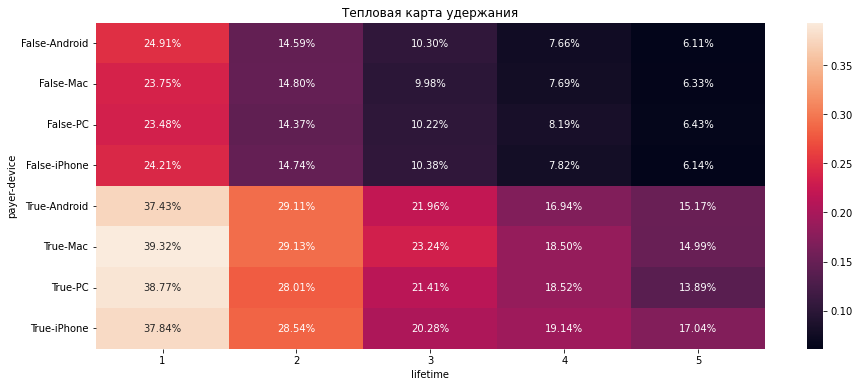

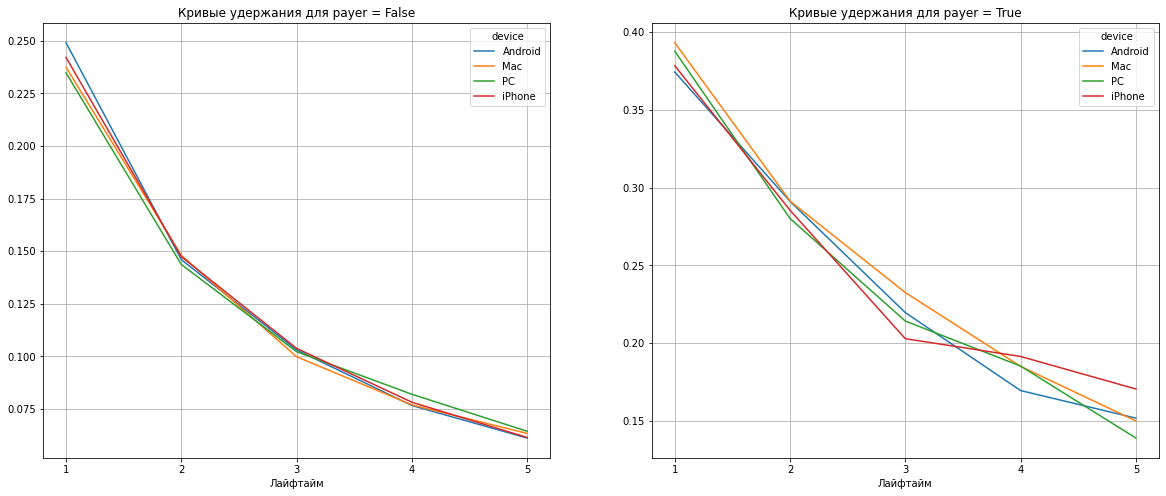

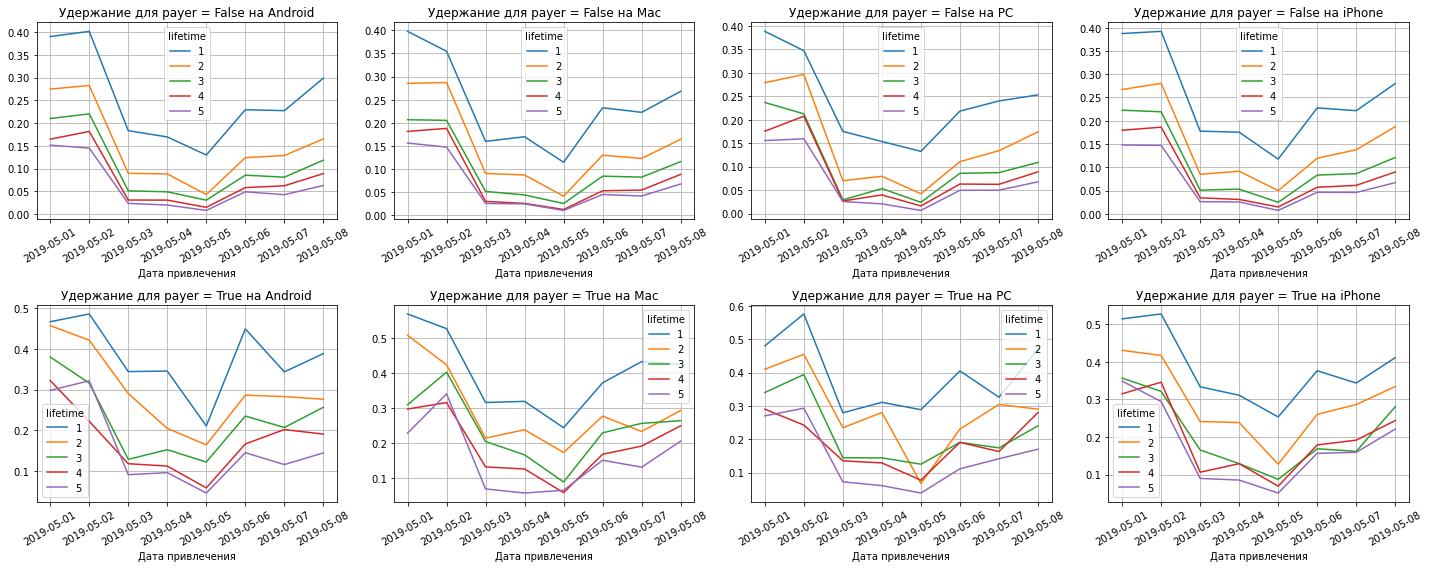

In [59]:
show_retention(
    sessions, event_dt='session_start',
    profiles=profiles,
    observation_date=datetime.date(2019, 5, 13),
    horizon=6,
    dimensions=['device'],
)

#### Conversion Rate в когортном анализе

Итак, конверсия - это доля людей, перешедших в новый этап, из состояния в состояние. Коэффициент конверсии когорты - это доля когорты, совершившей действие.

Чаще всего речь об оплате: из "неплатящих" в платящие. Когда растёт доля платящих - обычно это хорошо.

![Число плательщиков в выбранной когорте пользователей](https://pictures.s3.yandex.net/resources/Conversion_Rate_2_1620486051.png)

Смотрим внимательно: в таблице - число _первых_ покупок в лайфтайм в когорте. Ниже - общее число число _первых_ покупок в этой когорте, с начала наблюдений до завершения текущего лайфтайма.

Convertion Rate = накопленное число "конвертировавшихся" из когорты / размер когорты.

![Конверсия в когорте](https://pictures.s3.yandex.net/resources/Conversion_Rate_4_1620486122.png)

Тут тоже важны _горизонт наблюдения_ и _дата наблюдения_.

![Треугольная таблица](https://pictures.s3.yandex.net/resources/Conversion_Rate_5_1620486401.png)

![Её обработка](https://pictures.s3.yandex.net/resources/Conversion_Rate_6_1620486529.png)

Расчёт конверсии при когортном анализе очень похож на расчёт коэффициентов удержания и оттока. Отличие — в _исходных данных_. Если для удержания и оттока важно _количество активных пользователей_ в каждый из дней «жизни», то для конверсии — _количество первых покупок_.

Как рассчитать Conversion Rate по когортам:
1. Получить пользовательские профили и данные о покупках.
2. Найти дату и время первой покупки для каждого пользователя.
3. Добавить данные о покупках в профили.
4. Рассчитать лайфтайм пользователя для каждой покупки.
5. Построить таблицу конверсии - сводную таблицу, в которой:
  - названия строк — это даты первого посещения пользователей,
  - названия столбцов — лайфтайм,
  - а значения в «ячейках» — количество уникальных идентификаторов пользователей.
6. Посчитать сумму с накоплением для каждой строки таблицы конверсии.
7. Вычислить размеры когорт и занести результаты в отдельную таблицу.
8. Разделить каждую «ячейку» таблицы конверсии на соответствующий размер когорты.

Если взглянуть, то понятно, что данные для конверсии (платежи) устроены так же, как данные для удержания (посещения). И профили достраиваются так же - поиском первых по времени событий. И прибавляются к событиям профили так же. Итого, шаги 1...4 делаются так: к платежам применить тот же `get_suitable_events()`.

5 и 6 шаги: способ группировки и aggfunc() при вычислениях конверсии - другой. Его и напишем. Может, потом оформить `get_retention()` и `get_conversion()` как единый декоратор над `get_retention/convertion_rates()`.

7 и 8 шаги: по сути как в удержании.

In [60]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282937 entries, 0 to 282936
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           282937 non-null  int64         
 1   region            282937 non-null  object        
 2   device            282937 non-null  object        
 3   channel           282937 non-null  object        
 4   session_duration  282937 non-null  float64       
 5   session_start     282937 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 13.0+ MB


In [61]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21167 entries, 0 to 21166
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   21167 non-null  int64         
 1   event_dt  21167 non-null  datetime64[ns]
 2   revenue   21167 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 496.2 KB


In [62]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141419 entries, 0 to 141418
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   user_id                 141419 non-null  int64         
 1   first_region            141419 non-null  object        
 2   first_device            141419 non-null  object        
 3   first_channel           141419 non-null  object        
 4   first_session_duration  141419 non-null  float64       
 5   first_session_start     141419 non-null  datetime64[ns]
 6   date                    141419 non-null  object        
 7   month                   141419 non-null  datetime64[ns]
 8   payer                   141419 non-null  bool          
dtypes: bool(1), datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 8.8+ MB


In [63]:
# выбираем покупки
suitable_purchases = get_suitable_events(
    orders,
    # добавляем их в профили, созданные на основе сессий
    profiles=get_profiles(
        # делаем так, чтобы время события у сессий и покупок
        # было под одинаковыми названиями - так их проще сравнить
        sessions.rename(columns={'session_start': 'event_dt'})
    )
)

suitable_purchases.head()

Переименованные колонки:
'region' => 'first_region'
'device' => 'first_device'
'channel' => 'first_channel'
'session_duration' => 'first_session_duration'
'event_dt' => 'first_event_dt'



,user_id,event_dt,revenue,first_region,first_device,first_channel,first_session_duration,first_event_dt,date,month,lifetime
0,10964006,2019-05-13 04:00:32,4.99,Germany,Mac,Yandex,18.358495,2019-05-12 04:50:17,2019-05-12,2019-05-01,0.0
1,12358165,NaT,NaN,United States,iPhone,Yandex,7.406291,2019-05-10 23:16:24,2019-05-10,2019-05-01,NaN
2,12545358,NaT,NaN,United States,Mac,Organic,44.586078,2019-05-05 19:22:46,2019-05-05,2019-05-01,NaN
3,16165560,NaT,NaN,United States,PC,Yandex,2.550662,2019-05-10 20:29:59,2019-05-10,2019-05-01,NaN
4,17733464,2019-05-13 10:46:16,4.99,France,iPhone,Organic,1.065799,2019-05-12 11:08:25,2019-05-12,2019-05-01,0.0


In [64]:
get_rates(suitable_purchases, kind='conversion', dimensions=['first_region'])

Признаки для анализа:
['first_region']


lifetime,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
first_region,,,,,,,,,,,,,
France,1.297297,1.497574,1.645184,1.742204,1.819127,1.866251,1.916147,1.952876,1.977824,2.007623,2.027027,2.046431,2.053361
Germany,1.291566,1.487952,1.617671,1.711647,1.782329,1.826506,1.865863,1.897992,1.930924,1.953414,1.974699,1.990361,1.995984
Russian Federation,1.273391,1.437956,1.555408,1.642336,1.708029,1.757133,1.793630,1.822827,1.857996,1.881885,1.896483,1.915063,1.915727
United States,1.294601,1.501888,1.638969,1.742724,1.818485,1.876472,1.922462,1.960453,1.986003,2.010442,2.029771,2.044435,2.048434


In [65]:
dimensions = ['first_region']

# сколько пользователей совершили действия в каждый лайфтайм
result = suitable_purchases.pivot_table(
    index=dimensions,
    columns='lifetime',
    values='user_id',
    aggfunc='nunique',
)

result

lifetime,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
first_region,,,,,,,,,,,,,,
France,1443,429,289,213,140,111,68,72,53,36,43,28,28,10
Germany,2490,726,489,323,234,176,110,98,80,82,56,53,39,14
Russian Federation,1507,412,248,177,131,99,74,55,44,53,36,22,28,1
United States,4501,1326,933,617,467,341,261,207,171,115,110,87,66,18


In [66]:
result = result.cumsum(axis=1)

result

lifetime,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
first_region,,,,,,,,,,,,,,
France,1443,1872,2161,2374,2514,2625,2693,2765,2818,2854,2897,2925,2953,2963
Germany,2490,3216,3705,4028,4262,4438,4548,4646,4726,4808,4864,4917,4956,4970
Russian Federation,1507,1919,2167,2344,2475,2574,2648,2703,2747,2800,2836,2858,2886,2887
United States,4501,5827,6760,7377,7844,8185,8446,8653,8824,8939,9049,9136,9202,9220


In [67]:
cohort_sizes = suitable_purchases.groupby('first_region').agg({'event_dt': 'count'})
cohort_sizes

,event_dt
first_region,
France,3121
Germany,5247
Russian Federation,3049
United States,9750


In [68]:
result.div(cohort_sizes['event_dt'], axis=0)

lifetime,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
first_region,,,,,,,,,,,,,,
France,0.462352,0.599808,0.692406,0.760654,0.805511,0.841077,0.862864,0.885934,0.902916,0.914450,0.928228,0.937200,0.946171,0.949375
Germany,0.474557,0.612922,0.706118,0.767677,0.812274,0.845817,0.866781,0.885458,0.900705,0.916333,0.927006,0.937107,0.944540,0.947208
Russian Federation,0.494260,0.629387,0.710725,0.768777,0.811742,0.844211,0.868481,0.886520,0.900951,0.918334,0.930141,0.937357,0.946540,0.946868
United States,0.461641,0.597641,0.693333,0.756615,0.804513,0.839487,0.866256,0.887487,0.905026,0.916821,0.928103,0.937026,0.943795,0.945641


In [69]:
def get_conversion(
    profiles,
    purchases,  # заменили sessions
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # Шаг 1. Получить пользовательские профили и данные о покупках
    # передаём их в качестве аргументов profiles и purchases

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - datetime.timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('date <= @last_suitable_acquisition_date')

    # Шаг 2. Найти дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # Шаг 3. Добавить данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # Шаг 4. Рассчитать лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_session_start']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):

        # Шаг 5. Построить таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )

        # Шаг 6. Посчитать сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)

        # Шаг 7. Вычислить размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        # Шаг 8. Объединить таблицы размеров когорт и конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        # Шаг 9. Разделить каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)

        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['date'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [70]:
profiles.head(5)

,user_id,first_region,first_device,first_channel,first_session_duration,first_session_start,date,month,payer
0,10964006,Germany,Mac,Yandex,18.358495,2019-05-12 04:50:17,2019-05-12,2019-05-01,True
1,12358165,United States,iPhone,Yandex,7.406291,2019-05-10 23:16:24,2019-05-10,2019-05-01,False
2,12545358,United States,Mac,Organic,44.586078,2019-05-05 19:22:46,2019-05-05,2019-05-01,False
3,16165560,United States,PC,Yandex,2.550662,2019-05-10 20:29:59,2019-05-10,2019-05-01,False
4,17733464,France,iPhone,Organic,1.065799,2019-05-12 11:08:25,2019-05-12,2019-05-01,True


In [71]:
orders.head(5)

,user_id,event_dt,revenue
0,55519067947,2019-05-01 06:49:16,4.99
1,831753022495,2019-05-01 05:13:14,4.99
2,284598472478,2019-05-01 17:30:59,4.99
3,725363192554,2019-05-01 04:43:16,4.99
4,324356134597,2019-05-01 23:05:43,4.99


В столбце `event_dt` датафрейма `orders` хранятся дата и время совершения покупки — как и предусмотрено в коде функции `get_conversion()`.

Рассчитаем конверсию с разбивкой по регионам, передав `get_conversion()` фреймы `profiles` и `orders`, а также столбец `region` в качестве параметра `dimensions`, и построим тепловую карту по таблице конверсии. Момент и горизонт анализа данных остаются прежними — 13 мая 2019 года и 6 дней соответственно.

In [72]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime.date(2019, 5, 13), 6, dimensions=['first_region']
)

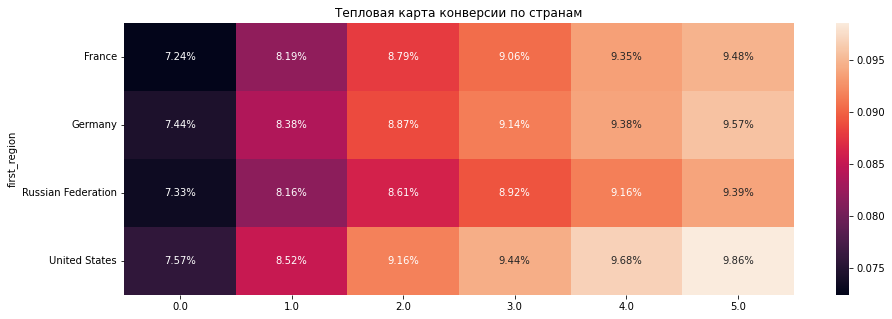

In [73]:
plt.figure(figsize=(15, 5))
sns.heatmap(conversion.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии по странам')
plt.show() 

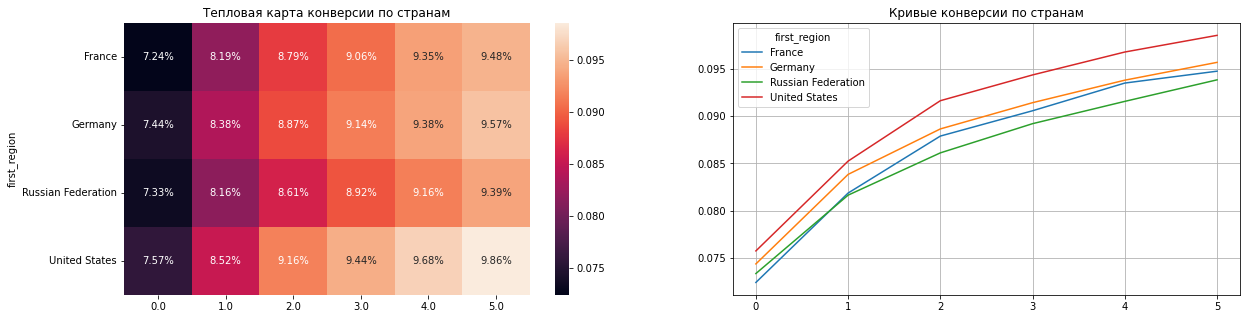

In [74]:
plt.figure(figsize = (20, 5)) # задаём размер «подложки»

# исключаем размеры когорт
# конверсии первого дня различаются, их удалять не нужно
report = conversion.drop(columns = ['cohort_size'])

sns.heatmap(
    report, annot=True, fmt='.2%', ax=plt.subplot(1, 2, 1)
)  # в первой ячейке таблицы графиков строим тепловую карту
plt.title('Тепловая карта конверсии по странам')

report.T.plot(
    grid=True, xticks=list(report.columns.values), ax=plt.subplot(1, 2, 2)
)  # во второй — кривые конверсии
plt.title('Кривые конверсии по странам')

plt.show()

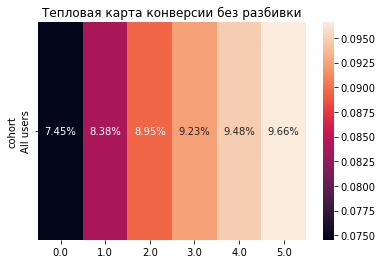

In [75]:
# считаем конверсию без параметра dimensions
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime.date(2019, 5, 13), 6
)

# строим хитмэп по таблице конверсии
sns.heatmap(conversion.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии без разбивки')
plt.show()

In [76]:
events, conversion, conversion_hist = get_conversion(
    profiles, orders, datetime.date(2019, 5, 13), 6, dimensions=['first_region']
)
conversion_hist

cohort_size       0.0       1.0       2.0  \
first_region       date                                                    
France             2019-05-01         1570  0.064331  0.074522  0.085350   
                   2019-05-02         1252  0.059904  0.075080  0.081470   
                   2019-05-03         1263  0.074426  0.082344  0.087886   
                   2019-05-04         1667  0.091182  0.098980  0.103179   
                   2019-05-05         1707  0.084359  0.091388  0.093732   
                   2019-05-06         1749  0.064037  0.073756  0.082333   
                   2019-05-07         1451  0.068229  0.075121  0.079256   
                   2019-05-08         1275  0.068235  0.080784  0.087059   
Germany            2019-05-01         2559  0.061352  0.071903  0.078546   
                   2019-05-02         2102  0.069933  0.083730  0.091342   
                   2019-05-03         2288  0.079545  0.086538  0.089598   
                   2019-05-04         2913  0.086509  0.092688  0.098867   
                   2019-05-05         2738  0.085829  0.094960  0.097882   
                   2019-05-06         2907  0.073271  0.082903  0.087719   
                   2019-05-07         2458  0.068348  0.078112  0.082181   
                   2019-05-08         2180  0.066055  0.077064  0.080275   
Russian Federation 2019-05-01         1589  0.050346  0.059786  0.062933   
                   2019-05-02         1323  0.061980  0.076342  0.081633   
                   2019-05-03         1430  0.074825  0.086014  0.093706   
                   2019-05-04         1728  0.089699  0.096644  0.100116   
                   2019-05-05         1679  0.100655  0.107207  0.108993   
                   2019-05-06         1725  0.069565  0.077681  0.081739   
                   2019-05-07         1485  0.065320  0.070034  0.073401   
                   2019-05-08         1326  0.068627  0.074661  0.082956   
United States      2019-05-01         4651  0.067082  0.079553  0.088153   
                   2019-05-02         3879  0.065223  0.077340  0.087136   
                   2019-05-03         4048  0.083498  0.091156  0.095603   
                   2019-05-04         5118  0.084408  0.094373  0.100430   
                   2019-05-05         5031  0.091234  0.096005  0.099781   
                   2019-05-06         5173  0.073265  0.084864  0.089697   
                   2019-05-07         4410  0.070295  0.078685  0.085488   
                   2019-05-08         3960  0.066667  0.076010  0.083838   

                                    3.0       4.0       5.0  
first_region       date                                      
France             2019-05-01  0.091720  0.094268  0.096815  
                   2019-05-02  0.086262  0.087859  0.090256  
                   2019-05-03  0.091053  0.091845  0.092637  
                   2019-05-04  0.104379  0.106779  0.106779  
                   2019-05-05  0.093732  0.096661  0.098418  
                   2019-05-06  0.085192  0.088622  0.089194  
                   2019-05-07  0.082702  0.087526  0.088215  
                   2019-05-08  0.087059  0.091765  0.093333  
Germany            2019-05-01  0.082063  0.084799  0.088316  
                   2019-05-02  0.094672  0.099429  0.100856  
                   2019-05-03  0.091783  0.094406  0.094843  
                   2019-05-04  0.100584  0.102300  0.103673  
                   2019-05-05  0.099708  0.101169  0.101534  
                   2019-05-06  0.090471  0.093911  0.096319  
                   2019-05-07  0.084215  0.086249  0.089504  
                   2019-05-08  0.085780  0.086239  0.088532  
Russian Federation 2019-05-01  0.066709  0.068597  0.072373  
                   2019-05-02  0.086924  0.090703  0.094482  
                   2019-05-03  0.095105  0.097203  0.098601  
                   2019-05-04  0.103588  0.104745  0.105324  
                   2019-05-05  0.112567  0.112567  0.114354  
                   2

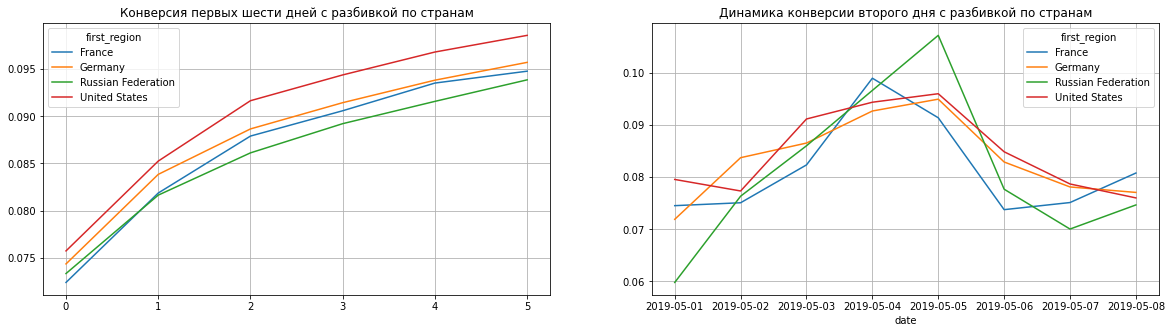

In [77]:
plt.figure(figsize=(20, 5))

report = conversion.drop(columns=['cohort_size'])
report.T.plot(
    grid=True, xticks=list(report.columns), ax=plt.subplot(1, 2, 1)
)
plt.title('Конверсия первых шести дней с разбивкой по странам')

# для графика истории изменений преобразуем таблицу динамики конверсии
report = (
    conversion_hist[1]
    .reset_index()
    .pivot_table(index='date', columns='first_region', values=1, aggfunc='mean')
    .fillna(0)
)

report.plot(
    grid=True, ax=plt.subplot(1, 2, 2)
)
plt.title('Динамика конверсии второго дня с разбивкой по странам')

plt.show()

## Юнит-экономика

Сколько зарабатывает бизнес с одного объекта.

Описывает, как:
- рассчитывать экономику одной продажи;
- определять, при каком объёме продаж бизнес выйдет в плюс;
- выбирать подходящую модель оплаты рекламы;
- считать пожизненную ценность, стоимость привлечения и окупаемость клиентов;
- быстро визуализировать основные метрики.

### С покупателя

Инвестиции в маркетинг строятся по принципу: «Вкладываем деньги в рекламу и получаем новые заказы. Если прибыль с заказа выше, чем затраты на его получение, значит, всё хорошо». Но на самом деле компании привлекают не заказы — привлекают покупателей, которые заказывают.

Главный принцип успешных инвестиций - полученный доход должен превысить затраты.

Чтобы включить в анализ повторные покупки, считают экономику одного покупателя. Три самые важные метрики в этом методе — LTV, CAC и ROI.

Для всех расчётов в когорте по-прежнему действуют правила. По-прежнему нужно выбирать когорты не моложе чем нужно, и выбирать лайфтаймы не больше чем нужно.

### LTV Lifetime Value (ARPU Average Revenue Per User)

Чем больше клиент дал денег - тем он лучше для нас.

Это общая сумма денег, которую один клиент в среднем приносит компании со всех своих покупок. В теории эта метрика включает все прошлые, нынешние и будущие покупки пользователя. На практике чаще анализируют LTV за определённый срок — первые 1, 3, 7 и 14 дней после регистрации. Другое название - ARPU - Average revenue per user.

    LTV = накопленная выручка с людей когорты / объём когорты

_Выручка от пользователей в каждый из лайфтаймов._
![Выручка](https://pictures.s3.yandex.net/resources/LTV_2_1643809761.png)

_Сводка по накопленной выручке в каждой когорте._
![Сводка](https://pictures.s3.yandex.net/resources/LTV_3_1620494437.png)

_Сводка по LTV в каждой когорте._
![Сводка LTV](https://pictures.s3.yandex.net/resources/LTV_4_1620494466.png)


#### ARPPU Average Revenue Per Paying User

    ARPPU = Выручка с когорты / количество тех из когорты, кто сделал хоть одну покупку.

Иногда используются вместо LTV. За счёт исключения неплатящих пользователей ARPPU часто более показателен, чем ARPU, но считать его труднее: во-первых, число платящих в когорте со временем растёт, а во-вторых, для расчёта требуются данные о том, делал ли покупку конкретный пользователь.

Выбор между ARPU и ARPPU **_отчасти__ зависит от способа оплаты рекламы**, которым пользуется компания. Самые распространённые — СPM, СPC, CPL/CPI и CPA.

**ARPU:**
- **CPM cost per mille** - сложно учитывать, потому что не каждый просмотр вызывает переход.
- **CPC cost per click** - оплаченный пользователь зашёл на сайт, ему можно закрепить куки, которые потом позволят понять, кто он, из какой когорты. Правда, куки не точны, теряются и блокируются/уничтожаются.
**ARPPU:**
- **CPL cost per lead, CPI cost per install** - оплата за пользователя, оставившего контакты или установившего прилогу. Идентификатор - логин / почта / телефон / рекламный ID устройства. Предпочитают её, а не CPA.
- **CPA cost per action** - оплата за действие (покупку, подписку, голос или ещё что то). Внедрять сложно, но подсчёт эффективности самый ясный.


#### Алгоритм
- Получить пользовательские профили и данные о покупках.
- Добавить данные о покупках в профили.
- Рассчитать лайфтайм пользователя для каждой покупки.
- Построить таблицу выручки. То есть сводную таблицу, в которой названия строк — это даты первого посещения пользователей, названия столбцов — лайфтайм, а значения в «ячейках» — выручка.
- Посчитать сумму с накоплением для каждой строки таблицы выручки.
- Вычислить размеры когорт и занести результаты в отдельную таблицу.
- Объединить таблицы размеров когорт и выручки.
- Посчитать LTV: разделить каждую «ячейку» таблицы выручки на соответствующий размер когорты.



In [78]:
profiles = profiles.rename(columns={'first_session_start': 'first_ts'})
profiles

,user_id,first_region,first_device,first_channel,first_session_duration,first_ts,date,month,payer
0,10964006,Germany,Mac,Yandex,18.358495,2019-05-12 04:50:17,2019-05-12,2019-05-01,True
1,12358165,United States,iPhone,Yandex,7.406291,2019-05-10 23:16:24,2019-05-10,2019-05-01,False
2,12545358,United States,Mac,Organic,44.586078,2019-05-05 19:22:46,2019-05-05,2019-05-01,False
3,16165560,United States,PC,Yandex,2.550662,2019-05-10 20:29:59,2019-05-10,2019-05-01,False
4,17733464,France,iPhone,Organic,1.065799,2019-05-12 11:08:25,2019-05-12,2019-05-01,True
...,...,...,...,...,...,...,...,...,...
141414,999939571625,Germany,iPhone,Yandex,21.279067,2019-05-08 17:47:00,2019-05-08,2019-05-01,False
141415,999954663782,United States,Android,AnotherSource,18.319029,2019-05-04 09:57:28,2019-05-04,2019-05-01,False
141416,999957797889,Russian Federation,Android,Yandex,19.478615,2019-05-14 21:54:26,2019-05-14,2019-05-01,False
141417,999974288578,France,iPhone,Organic,4.526489,2019-05-07 03:42:53,2019-05-07,2019-05-01,False


In [79]:
orders

,user_id,event_dt,revenue
0,55519067947,2019-05-01 06:49:16,4.99
1,831753022495,2019-05-01 05:13:14,4.99
2,284598472478,2019-05-01 17:30:59,4.99
3,725363192554,2019-05-01 04:43:16,4.99
4,324356134597,2019-05-01 23:05:43,4.99
...,...,...,...
21162,353771910308,2019-05-14 19:04:47,4.99
21163,166096415686,2019-05-14 15:24:08,4.99
21164,456767093617,2019-05-14 05:07:56,4.99
21165,352534243935,2019-05-14 23:55:17,4.99


In [80]:
def get_ltv(
    profiles,  # Шаг 1. Получить профили и данные о покупках
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - datetime.timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('date <= @last_suitable_acquisition_date')

    # Шаг 2. Добавить данные о покупках в профили

    result_raw = result_raw.merge(
        # добавляем в профили время совершения покупок и выручку
        purchases[['user_id', 'event_dt', 'revenue']],
        on='user_id',
        how='left',
    )

    # Шаг 3. Рассчитать лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):

        # Шаг 3. Построить таблицу выручки
        # строим «треугольную» таблицу
        result = df.pivot_table(
            index=dims,
            columns='lifetime',
            values='revenue',  # в ячейках — выручка за каждый лайфтайм
            aggfunc='sum',
        )

        # Шаг 4. Посчитать сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)

        # Шаг 5. Вычислить размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        # Шаг 6. Объединить размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        # Шаг 7. Посчитать LTV
        # делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу LTV
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики LTV убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []
    # получаем таблицу динамики LTV
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['date'], horizon_days
    )

    # возвращаем обе таблицы LTV и сырые данные
    return result_raw, result_grouped, result_in_time

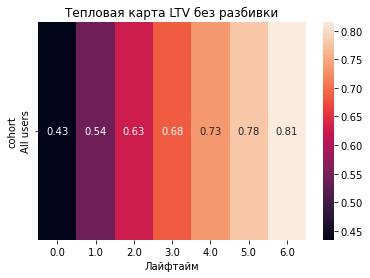

In [81]:
ltv_raw, ltv, ltv_history = get_ltv(
    profiles, orders, datetime.date(2019, 5, 13), 7
)

sns.heatmap(ltv.drop(columns=['cohort_size']), annot=True, fmt='.2f')
plt.title('Тепловая карта LTV без разбивки')
plt.xlabel('Лайфтайм')
plt.show()

LTV за неделю после привлечения составил 0,81 доллара на пользователя.

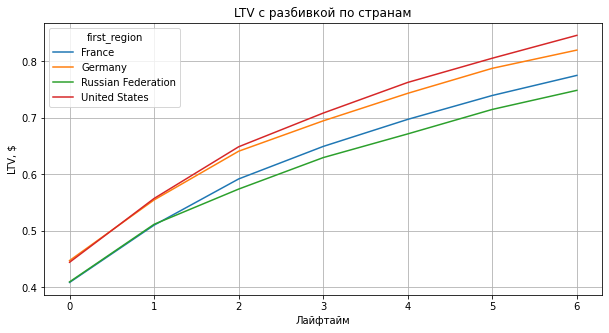

In [82]:
# строим кривые LTV

ltv_raw, ltv, ltv_history = get_ltv(
    profiles, orders, datetime.date(2019, 5, 13), 7, dimensions=['first_region']
)

report = ltv.drop(columns=['cohort_size'])
report.T.plot(grid=True, figsize=(10, 5), xticks=list(report.columns))
plt.title('LTV с разбивкой по странам')
plt.ylabel('LTV, $')
plt.xlabel('Лайфтайм')
plt.show()

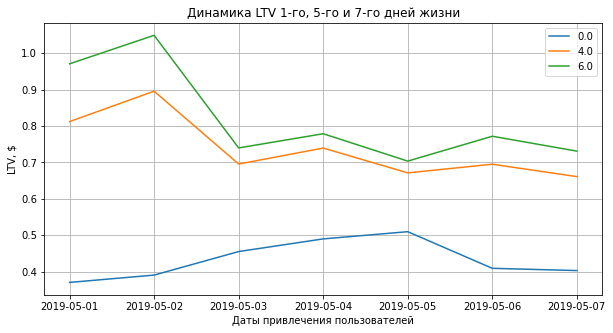

In [83]:
# график истории изменений LTV

ltv_raw, ltv, ltv_history = get_ltv(
    profiles, orders, datetime.date(2019, 5, 13), 7
)

report = ltv_history[[0, 4, 6]]
report.plot(grid=True, figsize=(10, 5))

plt.title('Динамика LTV 1-го, 5-го и 7-го дней жизни')
plt.ylabel('LTV, $')
plt.xlabel('Даты привлечения пользователей')
plt.show()

Признаки для анализа:
['payer']
Признаки для анализа:
['payer', 'date']


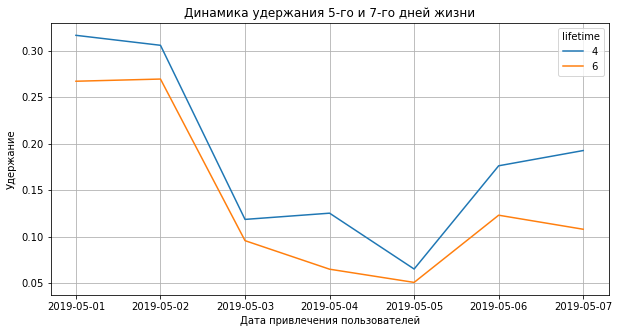

In [84]:
events, retention, retention_hist = get_retention_hist(
    sessions,
    profiles=profiles.rename(columns={'first_ts': 'first_session_start'}),
    observation_date=datetime.date(2019, 5, 13),
    horizon=7,
    event_dt='session_start',
)

report = retention_hist.query('payer == True').droplevel('payer')[[4, 6]]
report.plot(grid=True, figsize=(10, 5))
plt.title('Динамика удержания 5-го и 7-го дней жизни')
plt.ylabel('Удержание')
plt.xlabel('Дата привлечения пользователей')
plt.show()

Получается, в когортах с 3 по 5 мая - удержание маленькое. LTV нулевого дня в тех когортах велико, а вот пятого и седьмого дня - маленькие.

### CAC Customer Acquisition Cost

Это стоимость привлечения одного клиента. Сумма денег, в которую компании обходится каждый новый клиент.

CAC = Расходы на рекламу (инвестиции в маркетинг), привлёкшую когорту / размер когорты

Считается, что реклама (холодная) нужна только для формирования когорты, не для её удержания. Поэтому принято, что CAC окончательно рассчитывается в момент, как только когорта сформирована (закончился лайфтайм 0), и далее CAC этой когорты не меняется. Это **константа** для когорты.

_Сводка: LTV и дописанные перед ними расходы на рекламу и CAC._
![](https://pictures.s3.yandex.net/resources/LTV_5_1620494721.png)
_Вообще, поскольку есть полные расходы - логично будет дописать полные доходы с когорты._

Можно сравнивать CAC и LTV в лоб.

_График LTV по сравнению с CAC._
![](https://pictures.s3.yandex.net/resources/graph_2_1620494745.png)
_Когорта 1 апреля окупилась к концу второго дня существования. Когорта 2 апреля не окупилась по итогам семи дней. Судя по графику, маркетологи дорого купили трафик (в маркетинге так называют поток посетителей)._

#### Алгоритм

- Передать функции для создания профилей данные о тратах на рекламу.
- Объединить данные о тратах на рекламу и новых пользователях.
- Вычислить CAC: разделить рекламные расходы на количество новых пользователей.
- Добавить CAC для каждой даты привлечения и источника в профили.

In [85]:
costs = pd.read_csv(URL + 'ad_costs_new.csv')
costs['date'] = pd.to_datetime(costs.pop('dt')).dt.date
costs.head()

,channel,costs,date
0,AnotherSource,1826.0,2019-05-01
1,AnotherSource,1443.0,2019-05-02
2,AnotherSource,1508.0,2019-05-03
3,AnotherSource,1911.0,2019-05-04
4,AnotherSource,1837.0,2019-05-05


In [86]:
profiles = profiles.rename(columns={'first_channel': 'channel'})
profiles

,user_id,first_region,first_device,channel,first_session_duration,first_ts,date,month,payer
0,10964006,Germany,Mac,Yandex,18.358495,2019-05-12 04:50:17,2019-05-12,2019-05-01,True
1,12358165,United States,iPhone,Yandex,7.406291,2019-05-10 23:16:24,2019-05-10,2019-05-01,False
2,12545358,United States,Mac,Organic,44.586078,2019-05-05 19:22:46,2019-05-05,2019-05-01,False
3,16165560,United States,PC,Yandex,2.550662,2019-05-10 20:29:59,2019-05-10,2019-05-01,False
4,17733464,France,iPhone,Organic,1.065799,2019-05-12 11:08:25,2019-05-12,2019-05-01,True
...,...,...,...,...,...,...,...,...,...
141414,999939571625,Germany,iPhone,Yandex,21.279067,2019-05-08 17:47:00,2019-05-08,2019-05-01,False
141415,999954663782,United States,Android,AnotherSource,18.319029,2019-05-04 09:57:28,2019-05-04,2019-05-01,False
141416,999957797889,Russian Federation,Android,Yandex,19.478615,2019-05-14 21:54:26,2019-05-14,2019-05-01,False
141417,999974288578,France,iPhone,Organic,4.526489,2019-05-07 03:42:53,2019-05-07,2019-05-01,False


In [87]:
costs.merge(
    profiles.groupby(['date', 'channel']).agg({'user_id': 'nunique'}),
    on=['date', 'channel'],
)

,channel,costs,date,user_id
0,AnotherSource,1826.0000,2019-05-01,1867
1,AnotherSource,1443.0000,2019-05-02,1484
2,AnotherSource,1508.0000,2019-05-03,1560
3,AnotherSource,1911.0000,2019-05-04,1965
4,AnotherSource,1837.0000,2019-05-05,1910
5,AnotherSource,2192.3000,2019-05-06,2051
6,AnotherSource,1846.9000,2019-05-07,1738
7,AnotherSource,1664.3000,2019-05-08,1547
8,AnotherSource,1653.3000,2019-05-09,1541
9,AnotherSource,1931.6000,2019-05-10,1827


In [88]:
# добавляем параметр ad_costs — траты на рекламу
def get_cac_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['date'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            # проверяем, встречается ли каждый пользователь
            # среди тех, кто совершил событие event
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['date', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['date', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['date', 'channel', 'acquisition_cost']],
        on=['date', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles  # возвращаем профили с CAC

In [89]:
events = pd.read_csv(URL + 'events.csv')
events

,event_name,event_time,uid
0,pageview,2019-08-20 00:27:30,80419792
1,pageview,2019-01-29 08:11:30,74610198
2,pageview,2019-01-29 01:33:02,101714
3,pageview,2019-02-22 19:41:04,90089350
4,pageview,2019-03-04 12:49:09,98247028
...,...,...,...
15572,payment,2019-04-01 19:27:41,28487647
15573,payment,2019-04-01 19:29:20,28487647
15574,payment,2019-04-01 19:29:23,28487647
15575,payment,2019-04-01 19:29:29,28487647


In [90]:
profiles = get_cac_profiles(sessions, orders, events, costs)
profiles.head()

,user_id,first_ts,channel,device,region,date,month,payer,acquisition_cost
0,10964006,2019-05-12 04:50:17,Yandex,Mac,Germany,2019-05-12,2019-05-01,True,0.249238
1,12358165,2019-05-10 23:16:24,Yandex,iPhone,United States,2019-05-10,2019-05-01,False,0.239416
2,12545358,2019-05-05 19:22:46,Organic,Mac,United States,2019-05-05,2019-05-01,False,0.000000
3,16165560,2019-05-10 20:29:59,Yandex,PC,United States,2019-05-10,2019-05-01,False,0.239416
4,17733464,2019-05-12 11:08:25,Organic,iPhone,France,2019-05-12,2019-05-01,True,0.000000


Выясним, как меняется стоимость привлечения для каждого источника от когорты к когорте.

Для этого построим сводную таблицу, в которой:
- названиями строк будут даты привлечения пользователей,
- названиями столбцов — каналы привлечения,
- а значениями — средний CAC,

и построим по ней график истории изменений.

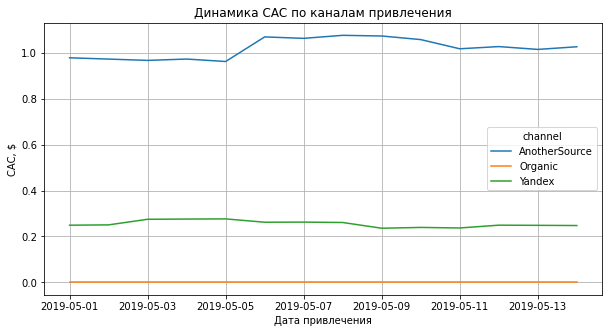

In [91]:
# строим график истории CAC по каналам привлечения

profiles.pivot_table(
    index='date', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(figsize=(10, 5), grid=True)
plt.title('Динамика CAC по каналам привлечения')
plt.xlabel('Дата привлечения')
plt.ylabel('CAC, $')
plt.show()

### ROI Return Of Investments

Когда сравниваешь много когорт по LTV и CAC одновременно - то линий вдвое больше чем надо. Ты по сути хочешь сравнить эффективность, окупаемость. Главный принцип успешных инвестиций — затраты не должны превышать полученный в результате доход.

ROI, или Return On Investment, — окупаемость инвестиций. В экономике одного покупателя эта метрика показывает, на сколько процентов LTV превысил CAC. Ещё говорят: на сколько процентов «окупились» клиенты.

ROI = LTV / CAC = выручка с когорты / расходы на привлечение когорты

Почему не включаем в формулу себестоимость товаров? Потому что её учёт и подсчёт намного сложнее, требует неоправданно много усилий и времени.

_CAC и ROI (записанный на месте LTV)_
![](https://pictures.s3.yandex.net/resources/ROI_1_1620494905.png)



#### Алгоритм

- выбрать признак
- сосчитать LTV по признаку
- сосчитать CAC по признаку
- разделить таблицу LTV на серию CAC

In [92]:
costs.head()

,channel,costs,date
0,AnotherSource,1826.0,2019-05-01
1,AnotherSource,1443.0,2019-05-02
2,AnotherSource,1508.0,2019-05-03
3,AnotherSource,1911.0,2019-05-04
4,AnotherSource,1837.0,2019-05-05


In [93]:
orders.head()

,user_id,event_dt,revenue
0,55519067947,2019-05-01 06:49:16,4.99
1,831753022495,2019-05-01 05:13:14,4.99
2,284598472478,2019-05-01 17:30:59,4.99
3,725363192554,2019-05-01 04:43:16,4.99
4,324356134597,2019-05-01 23:05:43,4.99


In [94]:
ltv_raw, ltv, ltv_hist = get_ltv(
    profiles, orders, datetime.date(2019, 5, 13), 7, dimensions=['channel']
)

display(ltv)

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0
channel,,,,,,,,
AnotherSource,12575,0.305974,0.362008,0.416706,0.455056,0.482119,0.504817,0.531809
Organic,35273,0.494700,0.625516,0.723143,0.789780,0.849941,0.899009,0.936868
Yandex,24045,0.413276,0.515684,0.596086,0.649590,0.696990,0.742361,0.782424


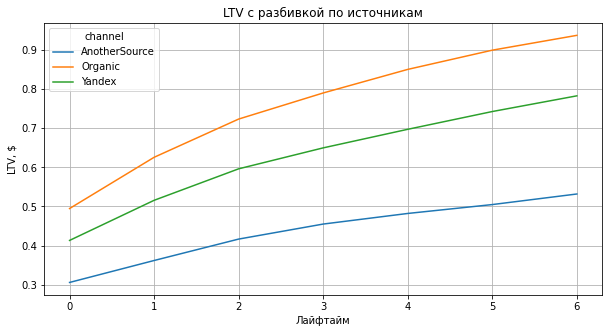

In [95]:
# кривые LTV
report = ltv.drop(columns=['cohort_size'])
report.T.plot(grid=True, figsize=(10, 5), xticks=list(report.columns))
plt.title('LTV с разбивкой по источникам')
plt.xlabel('Лайфтайм')
plt.ylabel('LTV, $')
plt.show()

In [96]:
ltv_raw.head()

,user_id,first_ts,channel,device,region,date,month,payer,acquisition_cost,event_dt,revenue,lifetime
0,12545358,2019-05-05 19:22:46,Organic,Mac,United States,2019-05-05,2019-05-01,False,0.000000,NaT,NaN,NaN
1,47343201,2019-05-07 16:55:48,Organic,iPhone,United States,2019-05-07,2019-05-01,False,0.000000,NaT,NaN,NaN
2,51602715,2019-05-03 14:57:36,Organic,iPhone,Russian Federation,2019-05-03,2019-05-01,False,0.000000,NaT,NaN,NaN
3,58494719,2019-05-04 08:31:04,Yandex,iPhone,Germany,2019-05-04,2019-05-01,False,0.275855,NaT,NaN,NaN
4,59432616,2019-05-03 07:06:42,Organic,iPhone,Germany,2019-05-03,2019-05-01,True,0.000000,2019-05-04 04:21:32,4.99,0.0


In [97]:
# самая поздняя подходящая дата привлечения из событий LTV
max_acquisition_dt = ltv_raw['date'].max()
# выбиваем только профили, которые старше этой даты
ltv_profiles = profiles.query('date <= @max_acquisition_dt')
# сколько пользователей в каждый лайфтайм?
ltv_profiles.groupby('date').agg({'user_id': 'nunique'})

,user_id
date,
2019-05-01,10369
2019-05-02,8556
2019-05-03,9029
2019-05-04,11426
2019-05-05,11155
2019-05-06,11554
2019-05-07,9804


In [98]:
cac = (
    ltv_profiles.groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .rename(columns={'acquisition_cost': 'cac'})
)

cac

,cac
channel,
AnotherSource,0.999141
Organic,0.000000
Yandex,0.264984


In [99]:
roi = ltv.div(cac['cac'], axis=0)
roi

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0
channel,,,,,,,,
AnotherSource,1.258581e+04,0.306237,0.362319,0.417064,0.455447,0.482534,0.505251,0.532266
Organic,inf,inf,inf,inf,inf,inf,inf,inf
Yandex,9.074137e+04,1.559627,1.946097,2.249517,2.451433,2.630310,2.801531,2.952722


Столбец c размерами когорт «сломался», а ROI органических пользователей устремился в бесконечность — из-за деления на ноль.

Затраты на привлечение органических пользователей нулевые, поэтому они всегда окупаются. А раз так, исключим их — удалим из результата все строки, в которых размер когорты равен бесконечности, применяя метод `isin()` и оператор `~` ("not"). Сравнивать значения с бесконечностью в Python позволяет переменная `inf` из библиотеки `numpy`.

In [100]:
roi = roi[~roi['cohort_size'].isin([np.inf])]
roi

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0
channel,,,,,,,,
AnotherSource,12585.809284,0.306237,0.362319,0.417064,0.455447,0.482534,0.505251,0.532266
Yandex,90741.367370,1.559627,1.946097,2.249517,2.451433,2.630310,2.801531,2.952722


In [101]:
roi.loc[:, 'cohort_size'] = ltv.loc[:, 'cohort_size']
roi

C:\Users\okean\AppData\Local\Temp\ipykernel_16780\221076903.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi.loc[:, 'cohort_size'] = ltv.loc[:, 'cohort_size']


,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0
channel,,,,,,,,
AnotherSource,12575,0.306237,0.362319,0.417064,0.455447,0.482534,0.505251,0.532266
Yandex,24045,1.559627,1.946097,2.249517,2.451433,2.630310,2.801531,2.952722


Таблица ROI готова.

Построим кривые ROI и добавим на график уровень окупаемости, вызвав функцию [`axhline()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axhline.html) из библиотеки `matplotlib`:

- `y` — координата линии по вертикальной оси,
- `color` — цвет линии,
- `linestyle` — стиль линии,
- `label` — подпись.

Уровень окупаемости установим на уровне `1`, линию сделаем красной (`color='red'`) и пунктирной (`linestyle='--'`). Чтобы добавить её в легенду, вызовем метод [`legend()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html) библиотеки `matplotlib`.

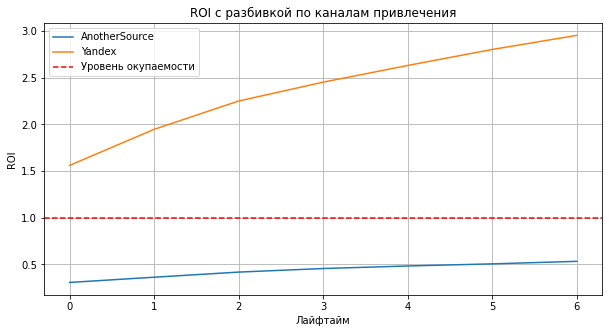

In [102]:
report = roi.drop(columns=['cohort_size'])
report.T.plot(grid=True, figsize=(10, 5), xticks=list(report.columns.values))

plt.title('ROI с разбивкой по каналам привлечения')
plt.ylabel('ROI')
plt.xlabel('Лайфтайм')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.show()

Судя по графику, реклама в «Яндексе» окупилась в среднем на 200%, а вот реклама в `AnotherSource` не окупилась вовсе.

### Функция для расчёта LTV, CAC и ROI

Чтобы всякий раз не повторять действия выше при расчёте ROI по новым данным, добавим их в функцию для расчёта пожизненной ценности `get_ltv()`:

- рассчитаем CAC,
- разделим LTV на CAC,
- удалим строки с бесконечным ROI.

In [103]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - datetime.timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('date <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['date'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [104]:
# рассчитываем LTV и ROI

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime.date(2019, 5, 13), 7, dimensions=['channel']
)

roi  # таблица ROI

,cohort_size,cac,0.0,1.0,2.0,3.0,4.0,5.0,6.0
channel,,,,,,,,,
AnotherSource,12575,0.999141,0.306237,0.362319,0.417064,0.455447,0.482534,0.505251,0.532266
Yandex,24045,0.264984,1.559627,1.946097,2.249517,2.451433,2.630310,2.801531,2.952722


In [105]:
roi_history

cohort_size       cac       0.0       1.0       2.0  \
channel       date                                                              
AnotherSource 2019-05-01         1867  0.978040  0.249233  0.298970  0.416544   
              2019-05-02         1484  0.972372  0.260742  0.343756  0.426750   
              2019-05-03         1560  0.966667  0.377228  0.450033  0.494397   
              2019-05-04         1965  0.972519  0.364029  0.418864  0.452810   
              2019-05-05         1910  0.961780  0.406445  0.439042  0.463489   
              2019-05-06         2051  1.068893  0.264540  0.319167  0.351489   
              2019-05-07         1738  1.062658  0.230202  0.284238  0.341545   
Yandex        2019-05-01         3404  0.249119  1.457111  2.124623  2.596604   
              2019-05-02         2933  0.250511  1.458932  2.018564  2.563280   
              2019-05-03         3031  0.274909  1.485317  1.706895  1.935674   
              2019-05-04         3861  0.275855  1.670023  1.984959  2.253888   
              2019-05-05         3744  0.276542  1.755461  1.972339  2.112124   
              2019-05-06         3872  0.262093  1.559914  2.024132  2.310310   
              2019-05-07         3200  0.262582  1.443239  1.763925  2.026426   

                               3.0       4.0       5.0       6.0  
channel       date                                                
AnotherSource 2019-05-01  0.468467  0.509458  0.550997  0.616632  
              2019-05-02  0.499390  0.547803  0.599674  0.651552  
              2019-05-03  0.544092  0.560637  0.583800  0.600345  
              2019-05-04  0.492548  0.519184  0.524406  0.532240  
              2019-05-05  0.477071  0.485220  0.490653  0.504235  
              2019-05-06  0.379715  0.404753  0.411581  0.434343  
              2019-05-07  0.365862  0.392880  0.428004  0.444215  
Yandex        2019-05-01  2.949670  3.279198  3.639328  3.975920  
              2019-05-02  2.912365  3.212548  3.539898  3.846996  
              2019-05-03  2.080600  2.212349  2.308167  2.387219  
              2019-05-04  2.356961  2.483459  2.563106  2.610896  
              2019-05-05  2.251976  2.310776  2.413039  2.480541  
              2019-05-06  2.507979  2.680078  2.866957  3.049008  
              2019-05-07  2.210523  2.400559  2.501516  2.597724

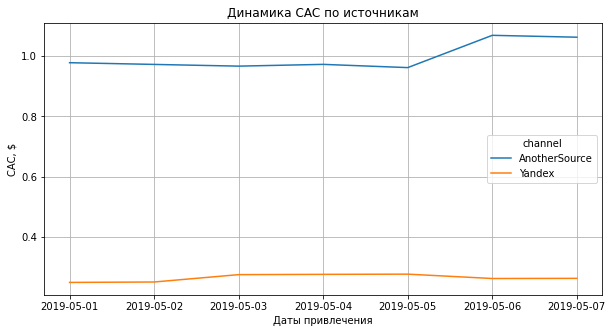

In [106]:
roi_history.pivot_table(
    index='date', columns='channel', values='cac', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.title('Динамика CAC по источникам')
plt.xlabel('Даты привлечения')
plt.ylabel('CAC, $')
plt.show()

Кроме того, таблица динамики ROI позволяет оценить изменения окупаемости в зависимости от канала и даты привлечения.

Построим график динамики ROI первого дня с разбивкой по каналам.

Для этого создадим сводную таблицу, в которой
- названиями строк окажутся даты привлечения пользователей,
- названиями столбцов — каналы,
- а значениями — среднее значение ROI по столбцу 0, в котором лежат данные за нулевой лайфтайм, или первый день «жизни».

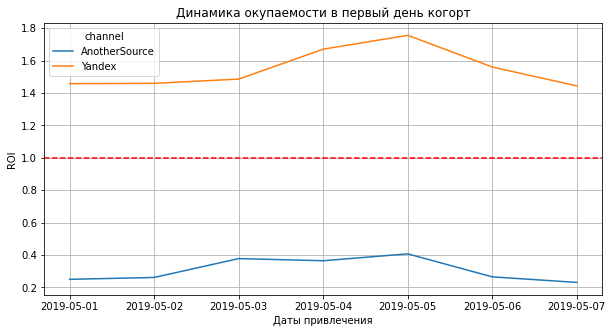

In [107]:
roi_history.pivot_table(
    index='date', columns='channel', values=0, aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.title('Динамика окупаемости в первый день когорт')
plt.xlabel('Даты привлечения')
plt.ylabel('ROI')
plt.axhline(label='Уровень окупаемости', y=1, color='red', linestyle='--')
plt.show()

График показывает, что реклама в Яндексе всегда окупалась в первый же день, реклама в ином источнике - никогда.

### Как проверить правдоподобость результата

Причины неверных результатов:
- "сломанные" данные;
- неучтённые момент и горизонт анализа;
- ошибки алгоритма;
- и другое.

#### Удержание Retention Rate:

- Сумма размеров когорт равна числу новых клиентов в изучаемый период.
- Сумма размеров платящих когорт равна числу покупателей в изучаемый период.
- Удержание убывает по [экспоненте](https://ru.wikipedia.org/wiki/Экспонента).
- Удержание неплатящих убывает быстрее, чем удержание платящих.